## Plot the main figure in the paper

used for large range

For image: sample_size_precentage = np.linspace(0.001, 0.5, 500)

For region 32x32: sample_size_precentage = np.linspace(0.00001, 0.01, 1000)

For region 16x16: sample_size_precentage = np.linspace(0.00001, 0.01, 1000)


In [1]:
import json
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import copy
from utils.utils import *

In [2]:
method_dict = {"MC": "Random Sample","random sample": "Random Sample", "surr ensemble": "ASE Class Score 0", "ASE": "ASE Class Score 0", "ASE_regression": "ASE Regression Score 0", 
               "ASE_all": "ASE All Score 0", "ASE_class_score_1": "ASE Class Score -1", "ASE_reg_score_1": "ASE Regression Score -1", "ASE_all_score_1": "ASE All Score -1", "MPL": "MPL"}
metric_dict = {'loss': 'Loss', 'mAP': 'mAP', "mAR_1000": "mAR"}
def add_entries(file):
    #columns=['active_test_type','sample_size','loss','mAP',"AP_50", "AP_75", "mAP_samll", "mAP_medium", "mAP_large", "mAR_1", "mAR_10", "mAR_1000", "mAR_small", "mAR_medium", "mAR_large"]
    with open(file, 'r') as openfile:
        json_object = json.load(openfile)
    df = None
    for key,value in json_object.items():
        if 'test_stats' in value.keys():
            del value['test_stats']
        value['active_test_type'] = method_dict[value['active_test_type']]
        if value['sample_size'] < 1:
            continue
        temp_df = pd.DataFrame(value, index=[key])
        if df is None:
            df = temp_df
        else:
            df = df.append(temp_df,ignore_index=True)
    return df

In [3]:
def plot_all_diff_precentage_figure(input_data, baseline_data, sample_nums, y_metric, x_label_name = "% of Acquired Images", 
                                    pic_name = None):
    data = copy.deepcopy(input_data)
    f = plt.figure(figsize=(10, 8))
    font_size = 25
    data[y_metric] = abs(data[y_metric] - baseline_data[y_metric])
    data[y_metric] = data[y_metric] / baseline_data[y_metric] * 100
    data['sample_size'] = data['sample_size'] / sample_nums * 100
    with sns.axes_style("darkgrid"):
        sns.lineplot(data=data, \
                     x='sample_size', y=y_metric, \
                     hue='active_test_type', errorbar=('sd', 1), lw=3)
        
    # x_line = [data['sample_size'][0], data['sample_size'][data['sample_size'].shape[0]-1]]
    # y_line = [0, 0]
    # plt.plot(x_line, y_line, 'r')
    # plt.title("Active Testing", fontsize=30)
    plt.xlabel(x_label_name, fontsize=font_size)# x轴标签
    plt.ylabel("% ER ", fontsize=font_size)# y轴标签
    # pic_name = scenario+'.png'
    plt.legend(fontsize = 18)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.tight_layout()
    # plt.style.use("fivethirtyeight")
    ax = plt.gca()
    ax.set_facecolor('none')
    #plt.ylim(-1600,-800)
    if pic_name is not None:
        plt.savefig(f'./figures/{pic_name}.png', bbox_inches='tight', pad_inches=0)
    plt.show()

def find_max_difference_with_each_baselines(results):
    rs = results[results["active_test_type"] == "Random Sample"]["loss"].values.reshape((-1,3)).mean(axis=1)
    ours = results[results["active_test_type"] == "our ViTAL"]["loss"].values.reshape((3,-1)).mean(axis=0)
    ase = results[results["active_test_type"] == "ASE"]["loss"].values.reshape((3,-1)).mean(axis=0)
    ats = results[results["active_test_type"] == "ATS"]["loss"].values.reshape((3,-1)).mean(axis=0)
    sample_size = results[results["active_test_type"] == "Random Sample"]["sample_size"].values.reshape((-1,3))[:,0]
    diff = np.expand_dims((1 - ours/rs), axis=0)
    diff = np.concatenate((diff, np.expand_dims((1 - ours/ase), axis=0)), axis=0)
    diff = np.concatenate((diff, np.expand_dims((1 - ours/ats), axis=0)), axis=0)
    diff_min = diff.min(axis=0)
    diff_min_max = diff_min.max()
    loc = sample_size[diff_min.argmax()]
    print(f"Max reducation compared with all approach: {diff_min_max:.2f}, loc : {loc}, ours: {ours[diff_min.argmax()]}, rs: {rs[diff_min.argmax()]}, ase: {ase[diff_min.argmax()]}, ats: {ats[diff_min.argmax()]}")    
    
def plot_figure(data, pic_name=None, x_label_name = "% of Acquired Labels"):
    y_metric = "loss"
    f = plt.figure(figsize=(10, 8))
    font_size = 25
    with sns.axes_style("darkgrid"):
        sns.lineplot(data=data, \
                     x='sample_size', y=y_metric, \
                     hue='active_test_type', errorbar=None, lw=3)
        
    # x_line = [data['sample_size'][0], data['sample_size'][data['sample_size'].shape[0]-1]]
    # y_line = [0, 0]
    # plt.plot(x_line, y_line, 'r')
    # plt.title("Active Testing", fontsize=30)
    # plt.xlabel(x_label_name, fontsize=font_size)# x轴标签
    # plt.ylabel("% Absolute ER ", fontsize=font_size)# y轴标签
    plt.title("")
    plt.xlabel("")# x轴标签
    plt.ylabel("")# y轴标签
    # pic_name = scenario+'.png'
    plt.legend(fontsize = 18)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.tight_layout()
    # plt.style.use("fivethirtyeight")
    ax = plt.gca()
    ax.set_facecolor('none')
    if pic_name is not None:
        # plt.savefig(f"./figures/{pic_name}.pdf",dpi=800)
        plt.savefig(f'./figures/{pic_name}.png', bbox_inches='tight', pad_inches=0)
    plt.show()
    find_max_difference_with_each_baselines(data)

def read_baseline_data(data_path):
    with open(data_path, 'r') as openfile:
        none_swin_data = json.load(openfile)
    return none_swin_data["0"]

def take_data_for_defined_point(model_dataset, steps, image_path, result_path, level):
    if model_dataset[-1] == "0":
        model_origin_folder = model_dataset[:-3]
    else:
        model_origin_folder = model_dataset
    base_path = f"./pro_data/{model_origin_folder}/val/"
    sample_size_threshold = np_read(base_path + image_path).shape[0]
    result_json_path = f"./results/{store_folder}/{model_dataset}/{result_path}/"
    true_loss_estimation_path = result_json_path + "None.json"
    test_whole_data = read_baseline_data(true_loss_estimation_path)
    results = add_entries(result_json_path + "random_sample_3_runs.json")
    results =  results.append(add_entries(result_json_path + f"ViT_{level}_runs_{steps}.json"),ignore_index=True)
    results =  results.append(add_entries(result_json_path + "ASE_runs.json"),ignore_index=True)
    results =  results.append(add_entries(result_json_path + "AT_runs.json"),ignore_index=True)
    min_size = int(min_size_p * sample_size_threshold)
    max_size = int(max_size_p * sample_size_threshold)
    results = results[results['sample_size'] >= min_size]
    results = results[results['sample_size'] <= max_size]
    y_metric = "loss"
    results[y_metric] = abs(results[y_metric] - test_whole_data[y_metric])
    results[y_metric] = results[y_metric] / test_whole_data[y_metric] * 100
    results['sample_size'] = results['sample_size'] / sample_size_threshold * 100
    return results

def print_mean_std(path, test_whole_data, sample_size_threshold):
    global temp_list
    data = add_entries(path)
    min_size = int(min_size_p * sample_size_threshold)
    max_size = int(max_size_p * sample_size_threshold)
    data = data[data['sample_size'] >= min_size]
    data = data[data['sample_size'] <= max_size]
    data = data['loss'].values
    data = data.reshape(3, data.shape[0]//3)
    data = (np.abs(data - test_whole_data) / test_whole_data) * 100
    mean = data.mean()
    std = data.mean(axis=1).std()
    print(f"{path}: mean {mean:.2f}, std {std:.2f}")
    temp_list.append(mean)
    temp_list.append(std)

def show_all_methods_mean_std(model_dataset, steps, image_path, result_path, level):
    global temp_list, result_pd
    if model_dataset[-1] == "0":
        model_origin_folder = model_dataset[:-3]
    else:
        model_origin_folder = model_dataset
    base_path = f"./pro_data/{model_origin_folder}/val/"
    sample_size_threshold = np_read(base_path + image_path).shape[0]
    result_json_path = f"./results/{store_folder}/{model_dataset}/{result_path}/"
    test_whole_data = read_baseline_data(result_json_path + "None.json")['loss']
    temp_list = []
    print_mean_std(result_json_path + "random_sample_3_runs.json", test_whole_data, sample_size_threshold)
    print_mean_std(result_json_path + f"ViT_{level}_runs_{steps}.json", test_whole_data, sample_size_threshold)
    print_mean_std(result_json_path + "ASE_runs.json", test_whole_data, sample_size_threshold)
    print_mean_std(result_json_path + "AT_runs.json", test_whole_data, sample_size_threshold)
    print("====================================================================================================")
    result_pd[model_dataset] = copy.deepcopy(temp_list)

## Object Detection

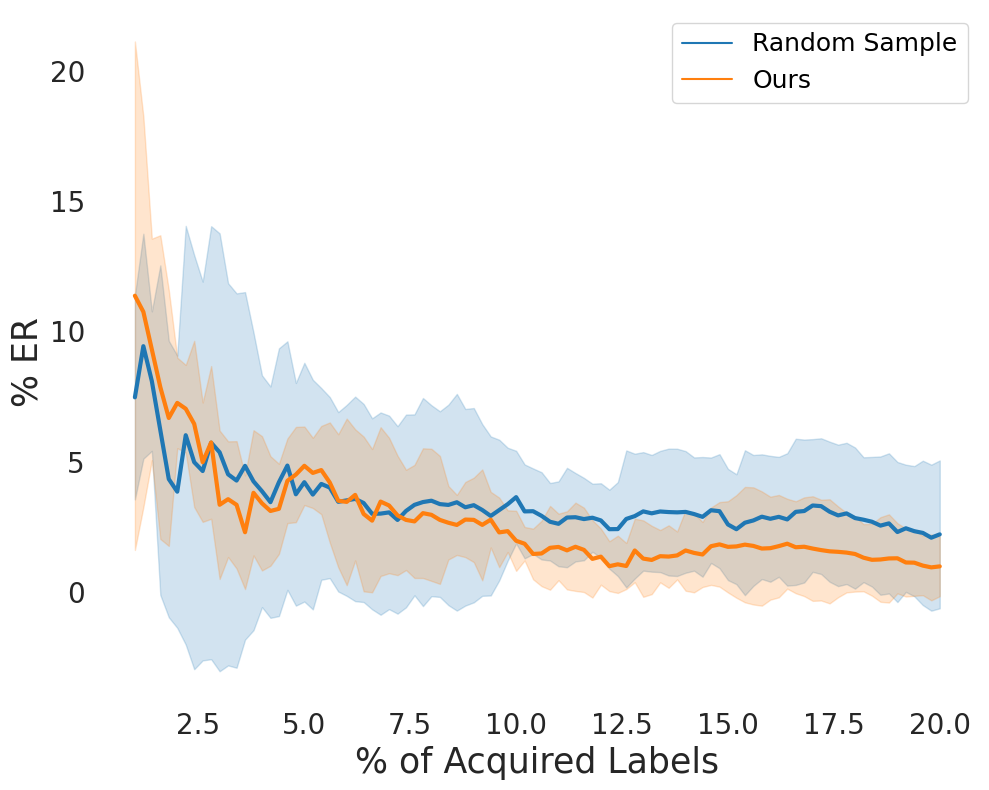

In [265]:
## image level
method_dict = {"random sample": "Random Sample", "RR": "Ours", "ABR":"Ours", "EGB": "EGB"}
base_path = "../../active_testing_det/orkspace/DINO/"
sample_size_threshold = np_read(base_path + "data/5_scale_31/val/pre_data/val_annotations.npy").shape[0]
result_json_path = base_path + f"results/active_test_image_level/"
true_loss_estimation_path = result_json_path + "None_R50_31.json"
test_whole_data = read_baseline_data(true_loss_estimation_path)
results = add_entries(result_json_path + "random_sample_R50_31_10_runs.json")
# results["loss"] += 0.01
# results =  results.append(add_entries(result_json_path + f"RedgeReg_R50_31_10_runs_1.json"),ignore_index=True)
results =  results.append(add_entries(result_json_path + f"RedgeReg_R50_31_10_runs_1.json"),ignore_index=True)
# results =  results.append(add_entries(result_json_path + f"EGB_R50_31_10_runs.json"),ignore_index=True)
# results =  results.append(add_entries(result_json_path + f"ABR_R50_31_10_runs.json"),ignore_index=True)
# results = results[results["sample_size"]>=400]
# results = results[results["sample_size"]<=2000]
plot_all_diff_precentage_figure(results, test_whole_data, sample_size_threshold, "loss", x_label_name = "% of Acquired Labels", pic_name = "Det_Image")

In [138]:
method_dict = {"random sample": "Random Sample", "ViT": "Ours"}
def show_det_box_results(steps, pic_name=None):
    base_path = "../../active_testing_det/orkspace/DINO/"
    sample_size_threshold = np_read(base_path + "data/5_scale_31/val/feature_pre_data/annotation.npy").shape[0]
    result_json_path = base_path + f"results/active_test_box_level_VIT/"
    true_loss_estimation_path = result_json_path + "None_R50_31.json"
    test_whole_data = read_baseline_data(true_loss_estimation_path)
    results = add_entries(result_json_path + "random_sample_R50_31_10_runs.json")
    results =  results.append(add_entries(result_json_path + f"ViT_runs_{steps}.json"),ignore_index=True)
    plot_all_diff_precentage_figure(results, test_whole_data, sample_size_threshold, "loss", x_label_name = "% of Acquired Labels", pic_name = pic_name)
    
    y_metric = "loss"
    results[y_metric] = abs(results[y_metric] - test_whole_data[y_metric])
    results[y_metric] = results[y_metric] / test_whole_data[y_metric] * 100
    return results

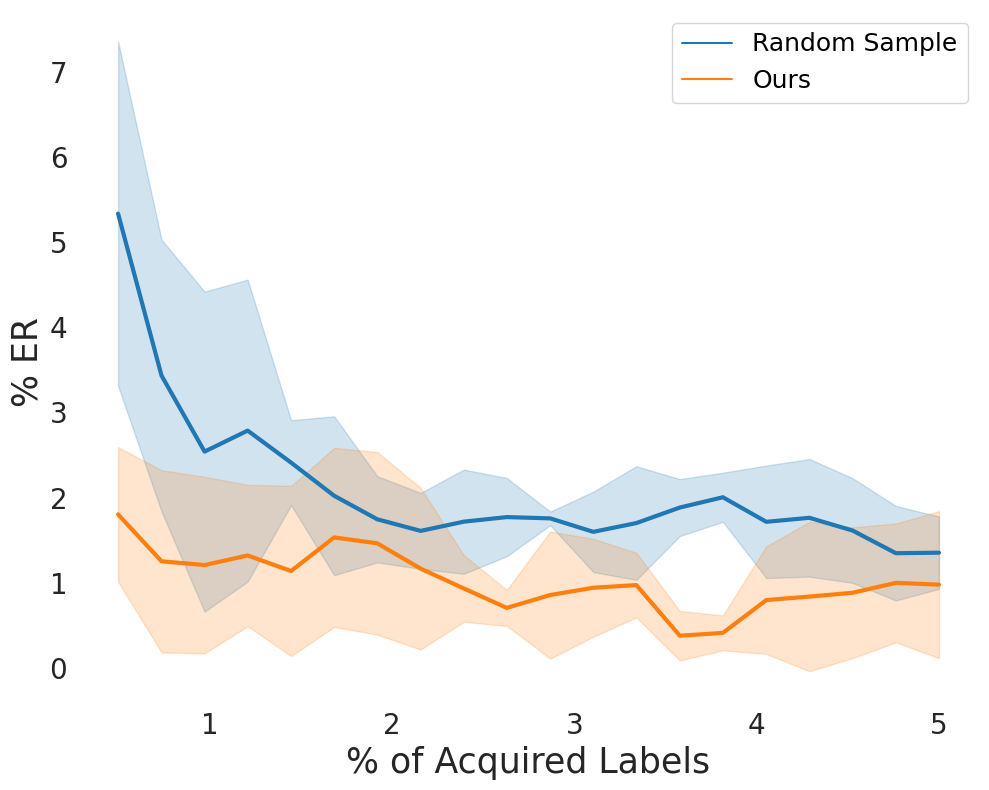

In [139]:
results = show_det_box_results(30000, pic_name = "Det_Box")

In [149]:
rs = results[results["active_test_type"] == "Random Sample"]["loss"].values.reshape((-1,3))
our = results[results["active_test_type"] == "Ours"]["loss"].values.reshape((-1,3))
diff_mean = 1 - our.mean(axis=1)/rs.mean(axis=1)
diff_std = 1 - our.std(axis=1) / rs.std(axis=1)
diff_mean.max(), diff_std.max()

(0.8003594157384095, 0.6094150129652354)

## Image Based

In [266]:
store_folder = "runs_3_large_range"
method_dict = {"random sample": "Random Sample", "ViT all": "our ViTAL", "ASE image":"ASE", "AT image": "ATS"}
def take_image_data_for_one_model_dataset(model_dataset, steps = 10000):
    if model_dataset[-1] == "0":
        model_origin_folder = model_dataset[:-3]
    else:
        model_origin_folder = model_dataset
    base_path = f"./pro_data/{model_origin_folder}/val/"
    sample_size_threshold = np_read(base_path + "image_true_losses.npy").shape[0]
    result_json_path = f"./results/{store_folder}/{model_dataset}/image_based_active_testing/"
    true_loss_estimation_path = result_json_path + "None.json"
    test_whole_data = read_baseline_data(true_loss_estimation_path)
    results = add_entries(result_json_path + "random_sample_3_runs.json")
    results =  results.append(add_entries(result_json_path + f"ViT_all_runs_{steps}.json"),ignore_index=True)
    results =  results.append(add_entries(result_json_path + "ASE_runs.json"),ignore_index=True)
    results =  results.append(add_entries(result_json_path + "AT_runs.json"),ignore_index=True)
    y_metric = "loss"
    results[y_metric] = abs(results[y_metric] - test_whole_data[y_metric])
    results[y_metric] = results[y_metric] / test_whole_data[y_metric] * 100
    results['sample_size'] = results['sample_size'] / sample_size_threshold * 100
    return results

def take_image_data_for_defined_point(model_dataset, steps = 10000):
    return take_data_for_defined_point(model_dataset, steps, "image_true_losses.npy", "image_based_active_testing", "all")


def show_image_all_methods_mean_std(model_dataset, steps = 10000):
    show_all_methods_mean_std(model_dataset, steps, "image_true_losses.npy", "image_based_active_testing", "all")

min_size_p = 0.01
max_size_p = 0.05

result_pd = {}
temp_list = []

In [268]:
dataset_model = "PSPNet_COCO_80"

step_array = np.arange(5000, 20001, 5000)
for step in step_array:
    show_image_all_methods_mean_std(dataset_model, step)

./results/runs_3_large_range/PSPNet_COCO_80/image_based_active_testing/random_sample_3_runs.json: mean 22.67, std 3.50
./results/runs_3_large_range/PSPNet_COCO_80/image_based_active_testing/ViT_all_runs_5000.json: mean 19.60, std 3.14
./results/runs_3_large_range/PSPNet_COCO_80/image_based_active_testing/ASE_runs.json: mean 10.29, std 1.01
./results/runs_3_large_range/PSPNet_COCO_80/image_based_active_testing/AT_runs.json: mean 22.69, std 7.47
./results/runs_3_large_range/PSPNet_COCO_80/image_based_active_testing/random_sample_3_runs.json: mean 22.67, std 3.50
./results/runs_3_large_range/PSPNet_COCO_80/image_based_active_testing/ViT_all_runs_10000.json: mean 78.96, std 76.07
./results/runs_3_large_range/PSPNet_COCO_80/image_based_active_testing/ASE_runs.json: mean 10.29, std 1.01
./results/runs_3_large_range/PSPNet_COCO_80/image_based_active_testing/AT_runs.json: mean 22.69, std 7.47
./results/runs_3_large_range/PSPNet_COCO_80/image_based_active_testing/random_sample_3_runs.json: mean

In [ ]:
result_pd = {}
temp_list = []
show_image_all_methods_mean_std("PSPNet_VOC_30", 5000)
show_image_all_methods_mean_std("UNet_VOC", 10000)
show_image_all_methods_mean_std("SEGNet_VOC", 20000)
show_image_all_methods_mean_std("FCN_VOC", 5000)

show_image_all_methods_mean_std("PSPNet_CITY_90", 15000)
show_image_all_methods_mean_std("UNet_CITY", 20000)
show_image_all_methods_mean_std("SEGNet_CITY", 5000)
show_image_all_methods_mean_std("FCN_CITY", 10000)

show_image_all_methods_mean_std("PSPNet_COCO_80", 20000)
show_image_all_methods_mean_std("UNet_COCO", 20000)
show_image_all_methods_mean_std("SEGNet_COCO", 5000)
show_image_all_methods_mean_std("FCN_COCO", 10000)

show_image_all_methods_mean_std("PSPNet_ADE20K", 65000)
show_image_all_methods_mean_std("UNet_ADE20K", 15000)
show_image_all_methods_mean_std("SEGNet_ADE20K", 25000)
show_image_all_methods_mean_std("FCN_ADE20K", 55000)
df = pd.DataFrame(result_pd)
df.to_excel('excel/image.xlsx', index=False)

In [ ]:
# result_pd = {}
# temp_list = []
# show_image_all_methods_mean_std("PSPNet_VOC", 20000)
# show_image_all_methods_mean_std("UNet_VOC", 10000)
# show_image_all_methods_mean_std("SEGNet_VOC", 20000)
# show_image_all_methods_mean_std("FCN_VOC", 5000)
# show_image_all_methods_mean_std("PSPNet_CITY_90", 15000)
# show_image_all_methods_mean_std("UNet_CITY", 20000)
# show_image_all_methods_mean_std("SEGNet_CITY", 5000)
# show_image_all_methods_mean_std("FCN_CITY", 10000)
# df = pd.DataFrame(result_pd)
# df.to_excel('excel/image_VOC.xlsx', index=False)

In [ ]:
# result_pd = {}
# temp_list = []
# show_image_all_methods_mean_std("PSPNet_COCO", 30000)
# show_image_all_methods_mean_std("UNet_COCO", 20000)
# show_image_all_methods_mean_std("SEGNet_COCO", 5000)
# show_image_all_methods_mean_std("FCN_COCO", 10000)

# show_image_all_methods_mean_std("PSPNet_ADE20K", 15000)
# show_image_all_methods_mean_std("UNet_ADE20K", 15000)
# show_image_all_methods_mean_std("SEGNet_ADE20K", 20000)
# show_image_all_methods_mean_std("FCN_ADE20K", 55000)
# df = pd.DataFrame(result_pd)
# df.to_excel('excel/image_COCO.xlsx', index=False)

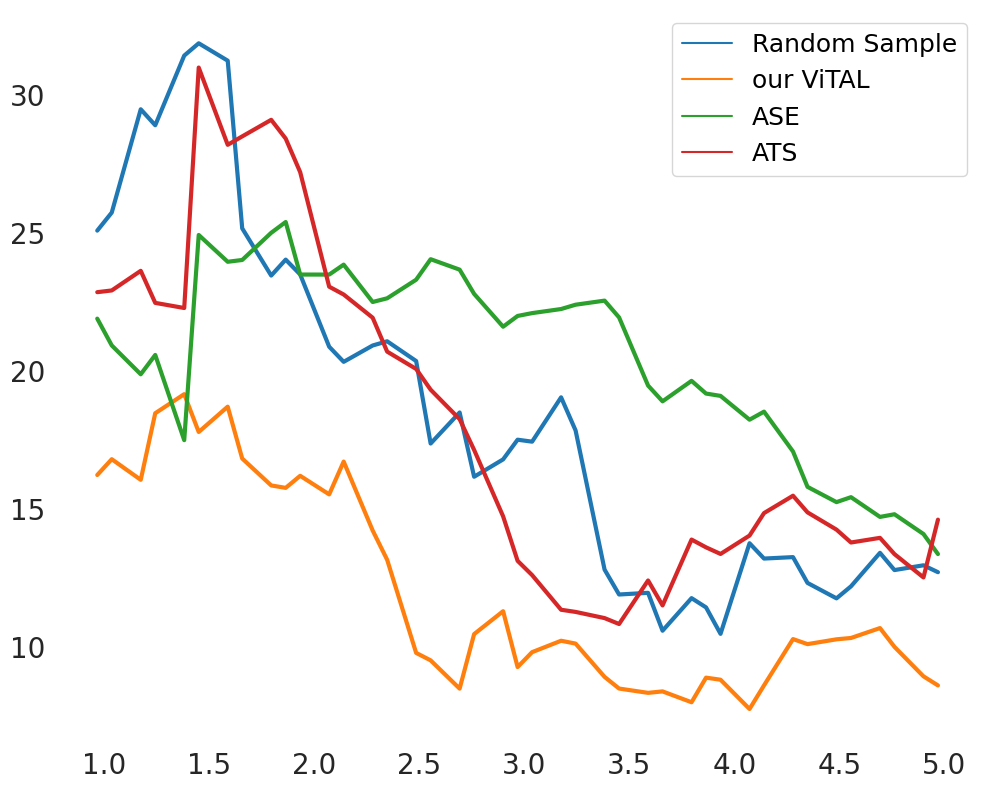

Max reducation compared with all approach: 0.79, loc : 4.278812974465148, ours: 4.137846278419862, rs: 23.394504118574304, ase: 30.51935297410492, ats: 19.505118748833024


In [248]:
results = take_image_data_for_defined_point("PSPNet_VOC_30", 5000)
results = results.append(take_image_data_for_defined_point("UNet_VOC", 10000))
results = results.append(take_image_data_for_defined_point("SEGNet_VOC", 20000))
results = results.append(take_image_data_for_defined_point("FCN_VOC", 5000))
plot_figure(results, "Image_VOC")

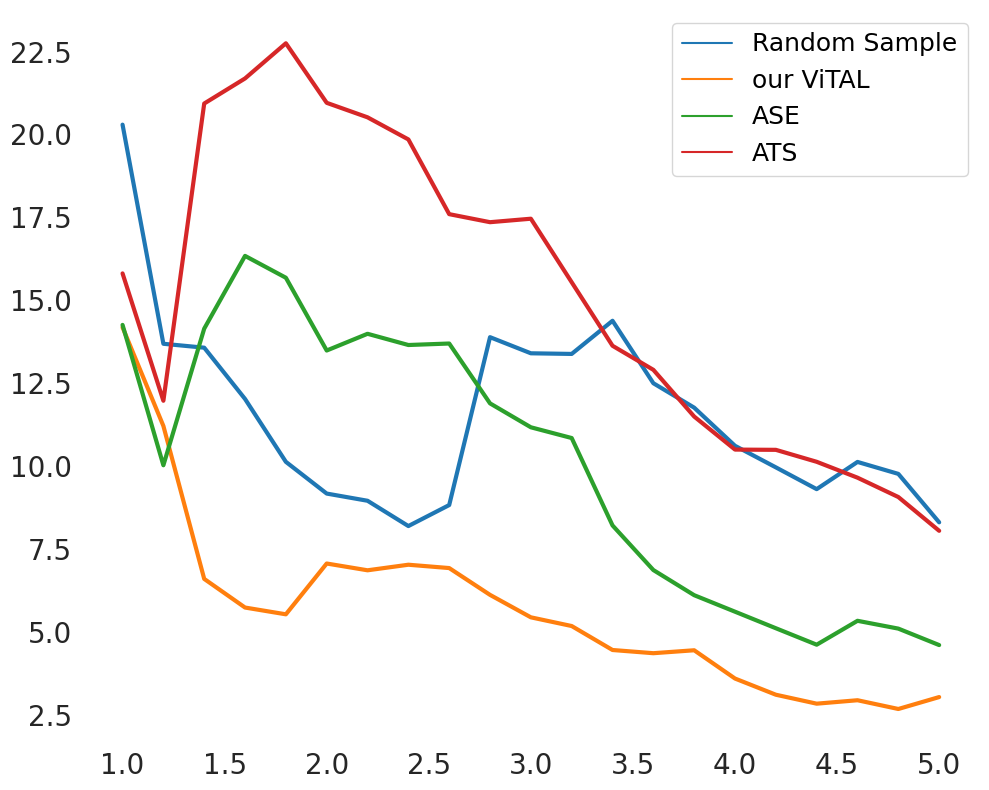

Max reducation compared with all approach: 0.74, loc : 2.1999999999999997, ours: 1.030626257245895, rs: 6.650756179628274, ase: 3.942789881359314, ats: 12.633706126675447


In [249]:
results = take_image_data_for_defined_point("PSPNet_CITY_90", 15000)
results = results.append(take_image_data_for_defined_point("UNet_CITY",  20000))
results = results.append(take_image_data_for_defined_point("SEGNet_CITY",  5000))
results = results.append(take_image_data_for_defined_point("FCN_CITY",  10000))
plot_figure(results, "Image_CITY")

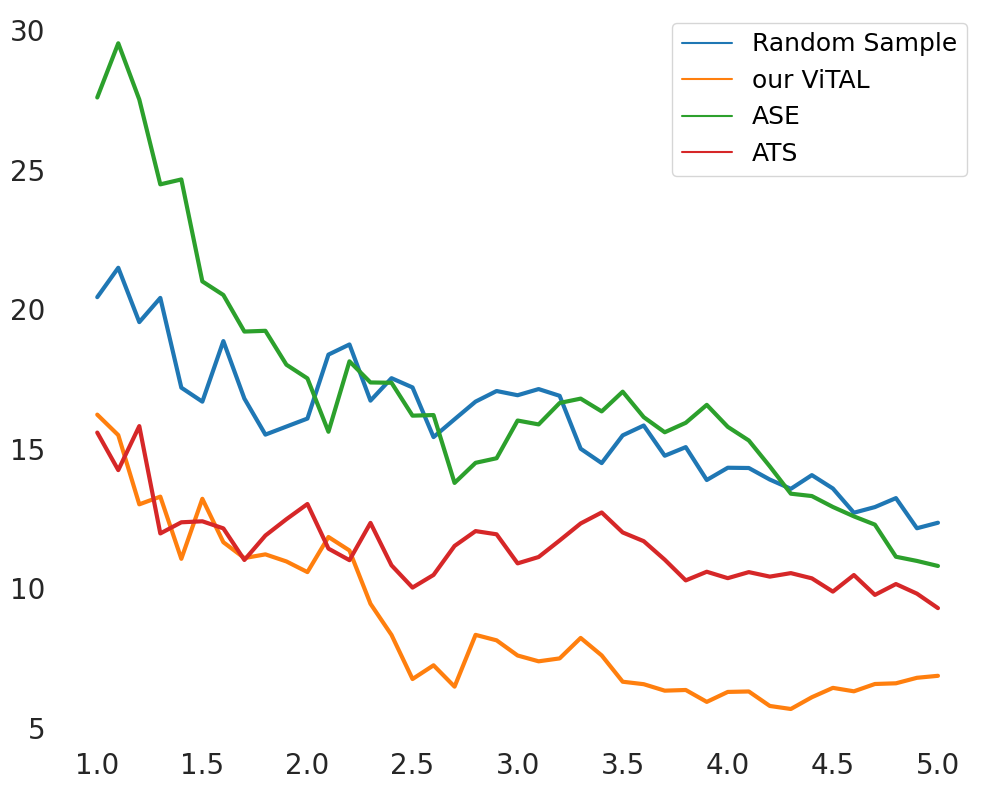

Max reducation compared with all approach: 0.75, loc : 2.7, ours: 3.6639535802767806, rs: 22.00220638723674, ase: 24.565157892660597, ats: 14.416645730665046


In [270]:
results = take_image_data_for_defined_point("PSPNet_COCO_80", 20000)
results = results.append(take_image_data_for_defined_point("UNet_COCO",  20000))
results = results.append(take_image_data_for_defined_point("SEGNet_COCO",  5000))
results = results.append(take_image_data_for_defined_point("FCN_COCO",  10000))
plot_figure(results, "Image_COCO")

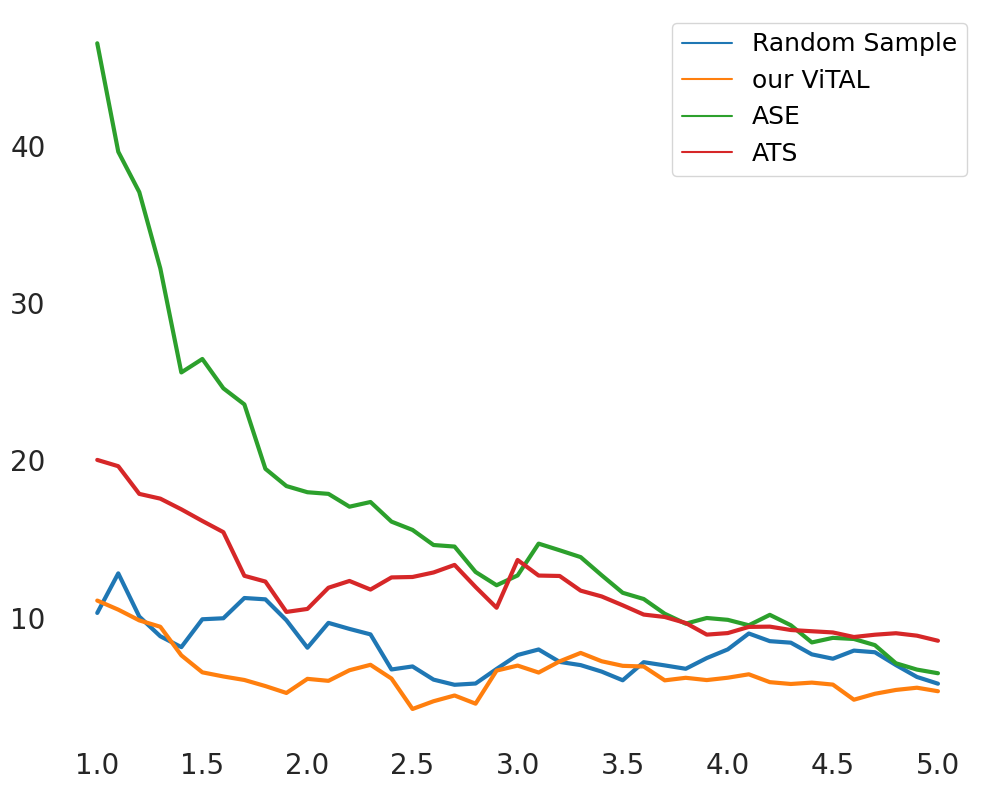

Max reducation compared with all approach: 0.76, loc : 2.3, ours: 2.24438707942193, rs: 9.464659735364352, ase: 27.007702299433788, ats: 23.31200250595892


In [251]:
results = take_image_data_for_defined_point("PSPNet_ADE20K",  65000)
results = results.append(take_image_data_for_defined_point("UNet_ADE20K",  15000))
results = results.append(take_image_data_for_defined_point("SEGNet_ADE20K",  25000))
results = results.append(take_image_data_for_defined_point("FCN_ADE20K",  55000))
plot_figure(results, "Image_ADE20K")

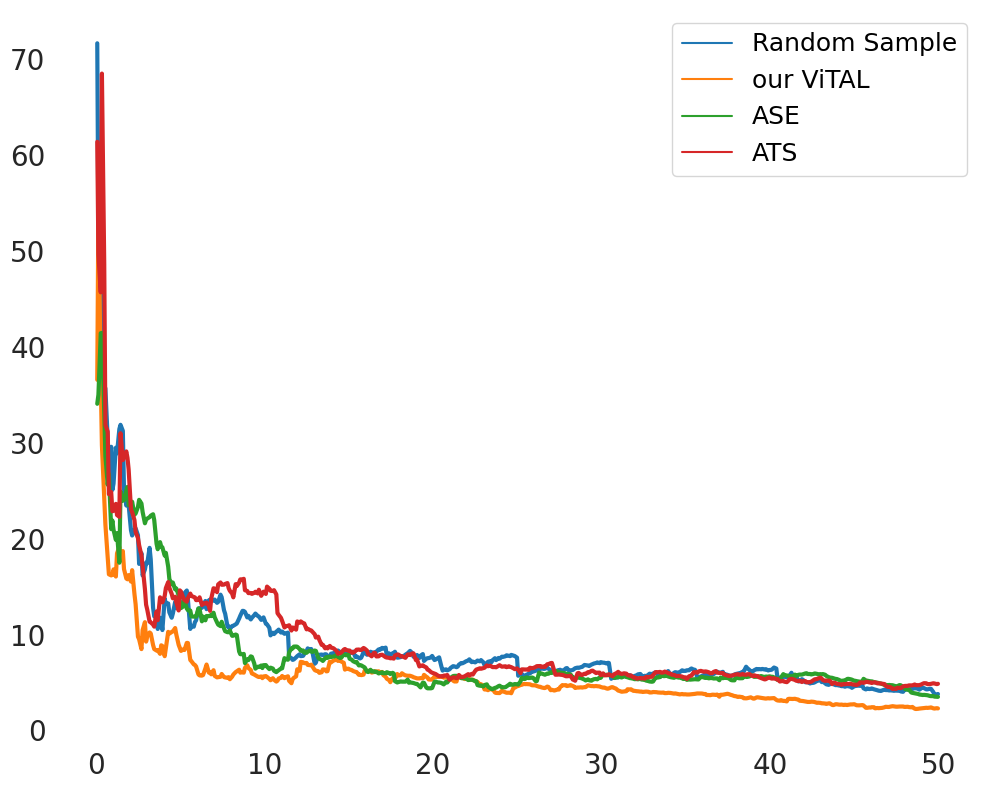

In [100]:
results = take_image_data_for_one_model_dataset("PSPNet_VOC_30", 5000)
results = results.append(take_image_data_for_one_model_dataset("UNet_VOC", 10000))
results = results.append(take_image_data_for_one_model_dataset("SEGNet_VOC", 20000))
results = results.append(take_image_data_for_one_model_dataset("FCN_VOC", 5000))
plot_figure(results)
# plot_figure(results, "Image_VOC")

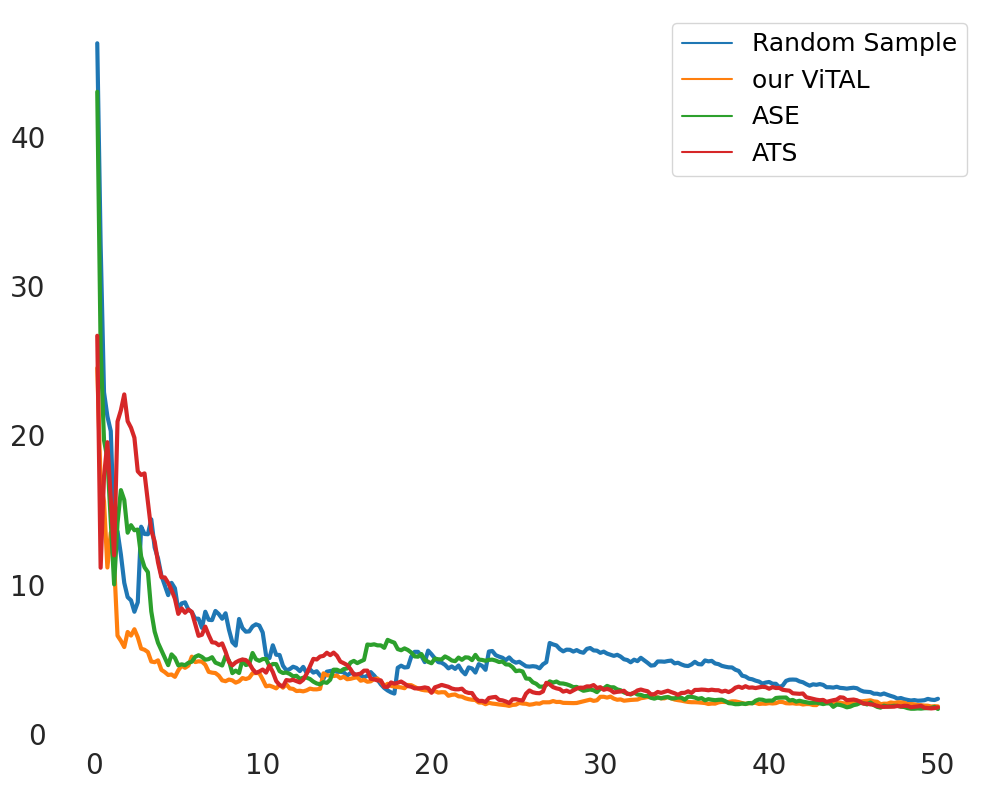

In [11]:
results = take_image_data_for_one_model_dataset("PSPNet_CITY_90", 15000)
results = results.append(take_image_data_for_one_model_dataset("UNet_CITY", 20000))
results = results.append(take_image_data_for_one_model_dataset("SEGNet_CITY", 5000))
results = results.append(take_image_data_for_one_model_dataset("FCN_CITY", 10000))
plot_figure(results)
# plot_figure(results, "Image_CITY")

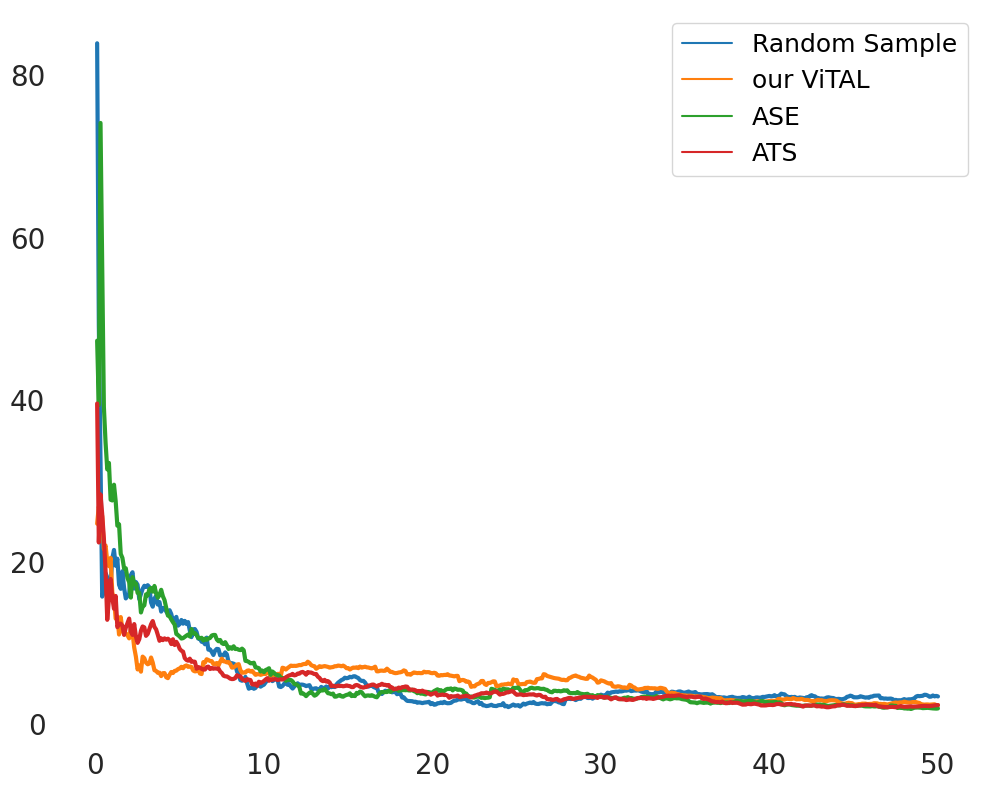

Max reducation compared with all approach: 0.75, loc : 2.7, ours: 3.6639535802767806, rs: 22.00220638723674, ase: 24.565157892660597, ats: 14.416645730665046


In [271]:
results = take_image_data_for_one_model_dataset("PSPNet_COCO_80", 20000)
results = results.append(take_image_data_for_one_model_dataset("UNet_COCO", 20000))
results = results.append(take_image_data_for_one_model_dataset("SEGNet_COCO", 5000))
results = results.append(take_image_data_for_one_model_dataset("FCN_COCO", 10000))
plot_figure(results)
# plot_figure(results, "Image_COCO")

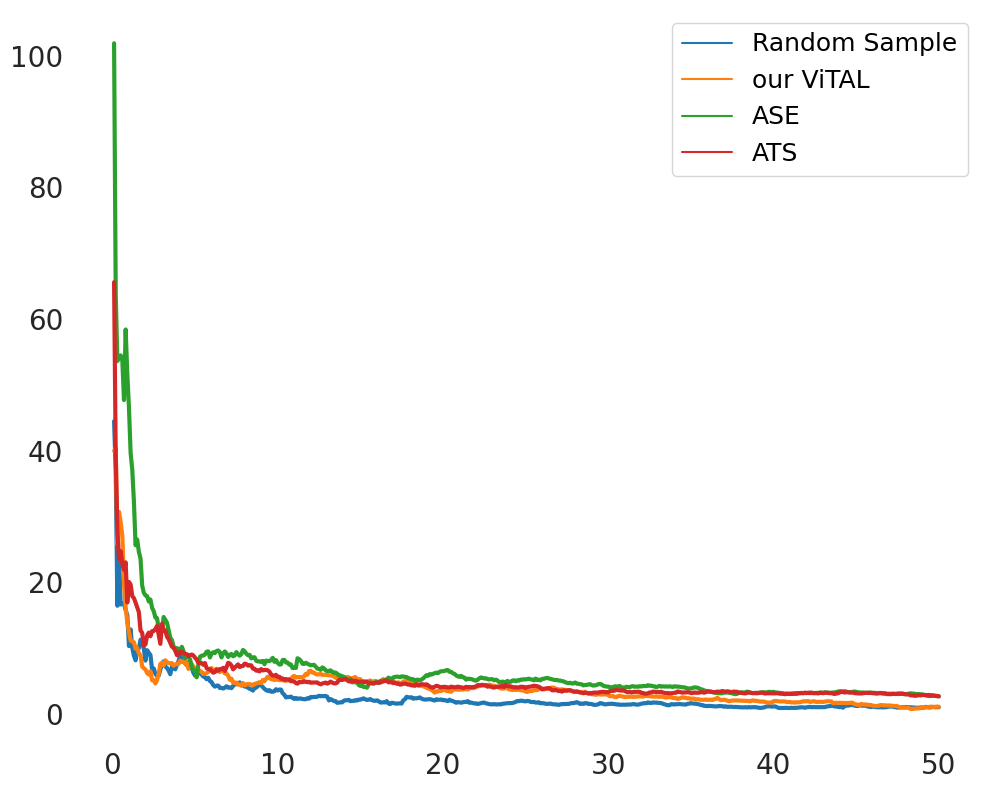

In [13]:
results = take_image_data_for_one_model_dataset("PSPNet_ADE20K", 15000)
results = results.append(take_image_data_for_one_model_dataset("UNet_ADE20K", 15000))
results = results.append(take_image_data_for_one_model_dataset("SEGNet_ADE20K", 20000))
results = results.append(take_image_data_for_one_model_dataset("FCN_ADE20K", 55000))
plot_figure(results)
# plot_figure(results, "Image_ADE20K")

In [14]:
# results = take_image_data_for_one_model_dataset("PSPNet_VOC", 20000)
# results = results.append(take_image_data_for_one_model_dataset("PSPNet_CITY_90", 15000))
# results = results.append(take_image_data_for_one_model_dataset("PSPNet_COCO", 5000))
# results = results.append(take_image_data_for_one_model_dataset("PSPNet_ADE20K", 15000))
# plot_figure(results, "Image_PSPNet")

## Region 16x16 based

In [272]:
store_folder = "runs_3_large_range"
method_dict = {"random sample": "Random Sample", "ViT region": "our ViTAL", "ASE region": "ASE", "AT region": "ATS", "ViT class 40": "our ViTAL"}
def take_region_16_data_for_one_model_dataset(model_dataset, steps = 10000):
    if model_dataset[-1] == "0":
        model_origin_folder = model_dataset[:-3]
    else:
        model_origin_folder = model_dataset
    base_path = f"./pro_data/{model_origin_folder}/val/"
    sample_size_threshold = np_read(base_path + "region_16_16_true_losses.npy").shape[0]
    result_json_path = f"./results/{store_folder}/{model_dataset}/region_16_16_active_testing/"
    true_loss_estimation_path = result_json_path + "None.json"
    test_whole_data = read_baseline_data(true_loss_estimation_path)
    results = add_entries(result_json_path + "random_sample_3_runs.json")
    results =  results.append(add_entries(result_json_path + f"ViT_region_runs_{steps}.json"),ignore_index=True)
    results =  results.append(add_entries(result_json_path + "ASE_runs.json"),ignore_index=True)
    results =  results.append(add_entries(result_json_path + "AT_runs.json"),ignore_index=True)
    y_metric = "loss"
    results[y_metric] = abs(results[y_metric] - test_whole_data[y_metric])
    results[y_metric] = results[y_metric] / test_whole_data[y_metric] * 100
    results['sample_size'] = results['sample_size'] / sample_size_threshold * 100
    return results

def take_region_16_data_for_defined_point(model_dataset,  steps = 10000):
    return take_data_for_defined_point(model_dataset,  steps, "region_16_16_true_losses.npy", "region_16_16_active_testing", "region")

def show_region_16_all_methods_mean_std(model_dataset, steps = 10000):
    show_all_methods_mean_std(model_dataset, steps, "region_16_16_true_losses.npy", "region_16_16_active_testing", "region")

min_size_p = 0.0001
max_size_p = 0.0008

"UNet_CITY_20", 20000

In [275]:
dataset_model = "UNet_CITY_10"

step_array = np.arange(5000, 20001, 5000)
for step in step_array:
    show_region_16_all_methods_mean_std(dataset_model, step)

./results/runs_3_large_range/UNet_CITY_10/region_16_16_active_testing/random_sample_3_runs.json: mean 14.22, std 3.52
./results/runs_3_large_range/UNet_CITY_10/region_16_16_active_testing/ViT_region_runs_5000.json: mean 14.32, std 8.32
./results/runs_3_large_range/UNet_CITY_10/region_16_16_active_testing/ASE_runs.json: mean 5.49, std 0.48
./results/runs_3_large_range/UNet_CITY_10/region_16_16_active_testing/AT_runs.json: mean 16.06, std 10.64
./results/runs_3_large_range/UNet_CITY_10/region_16_16_active_testing/random_sample_3_runs.json: mean 14.22, std 3.52
./results/runs_3_large_range/UNet_CITY_10/region_16_16_active_testing/ViT_region_runs_10000.json: mean 11.78, std 5.44
./results/runs_3_large_range/UNet_CITY_10/region_16_16_active_testing/ASE_runs.json: mean 5.49, std 0.48
./results/runs_3_large_range/UNet_CITY_10/region_16_16_active_testing/AT_runs.json: mean 16.06, std 10.64
./results/runs_3_large_range/UNet_CITY_10/region_16_16_active_testing/random_sample_3_runs.json: mean 14.

In [73]:
result_pd = {}
temp_list = []
show_region_16_all_methods_mean_std("PSPNet_VOC", 10000)
print("====================================================================================================")
show_region_16_all_methods_mean_std("UNet_VOC", 25000)
print("====================================================================================================")
show_region_16_all_methods_mean_std("SEGNet_VOC_30", 5000)
print("====================================================================================================")
show_region_16_all_methods_mean_std("FCN_VOC", 10000)
print("====================================================================================================")
show_region_16_all_methods_mean_std("PSPNet_CITY", 10000)
print("====================================================================================================")
show_region_16_all_methods_mean_std("UNet_CITY_20", 20000)
print("====================================================================================================")
show_region_16_all_methods_mean_std("SEGNet_CITY", 10000)
print("====================================================================================================")
show_region_16_all_methods_mean_std("FCN_CITY_40", 15000)
print("====================================================================================================")
show_region_16_all_methods_mean_std("PSPNet_COCO", 60000)
show_region_16_all_methods_mean_std("UNet_COCO", 15000)
show_region_16_all_methods_mean_std("SEGNet_COCO", 25000)
show_region_16_all_methods_mean_std("FCN_COCO", 25000)

show_region_16_all_methods_mean_std("PSPNet_ADE20K", 5000)
show_region_16_all_methods_mean_std("UNet_ADE20K", 15000)
show_region_16_all_methods_mean_std("SEGNet_ADE20K", 20000)
show_region_16_all_methods_mean_std("FCN_ADE20K", 35000)
df = pd.DataFrame(result_pd)
df.to_excel('excel/region_16.xlsx', index=False)

./results/runs_3_large_range/PSPNet_VOC/region_16_16_active_testing/random_sample_3_runs.json: mean 19.89, std 12.77
./results/runs_3_large_range/PSPNet_VOC/region_16_16_active_testing/ViT_region_runs_10000.json: mean 8.12, std 1.84
./results/runs_3_large_range/PSPNet_VOC/region_16_16_active_testing/ASE_runs.json: mean 9.36, std 4.81
./results/runs_3_large_range/PSPNet_VOC/region_16_16_active_testing/AT_runs.json: mean 9.63, std 4.36
./results/runs_3_large_range/UNet_VOC/region_16_16_active_testing/random_sample_3_runs.json: mean 4.96, std 0.56
./results/runs_3_large_range/UNet_VOC/region_16_16_active_testing/ViT_region_runs_25000.json: mean 4.27, std 1.40
./results/runs_3_large_range/UNet_VOC/region_16_16_active_testing/ASE_runs.json: mean 4.12, std 0.82
./results/runs_3_large_range/UNet_VOC/region_16_16_active_testing/AT_runs.json: mean 3.70, std 0.80
./results/runs_3_large_range/SEGNet_VOC/region_16_16_active_testing/random_sample_3_runs.json: mean 19.09, std 6.50
./results/runs_3_l

In [74]:
dataset_model = "UNet_VOC"

step_array = np.arange(5000, 25001, 5000)
for step in step_array:
    show_region_16_all_methods_mean_std(dataset_model, step)

./results/runs_3_large_range/UNet_VOC/region_16_16_active_testing/random_sample_3_runs.json: mean 4.96, std 0.56
./results/runs_3_large_range/UNet_VOC/region_16_16_active_testing/ViT_region_runs_5000.json: mean 4.97, std 1.46
./results/runs_3_large_range/UNet_VOC/region_16_16_active_testing/ASE_runs.json: mean 4.12, std 0.82
./results/runs_3_large_range/UNet_VOC/region_16_16_active_testing/AT_runs.json: mean 3.70, std 0.80
./results/runs_3_large_range/UNet_VOC/region_16_16_active_testing/random_sample_3_runs.json: mean 4.96, std 0.56
./results/runs_3_large_range/UNet_VOC/region_16_16_active_testing/ViT_region_runs_10000.json: mean 8.97, std 3.87
./results/runs_3_large_range/UNet_VOC/region_16_16_active_testing/ASE_runs.json: mean 4.12, std 0.82
./results/runs_3_large_range/UNet_VOC/region_16_16_active_testing/AT_runs.json: mean 3.70, std 0.80
./results/runs_3_large_range/UNet_VOC/region_16_16_active_testing/random_sample_3_runs.json: mean 4.96, std 0.56
./results/runs_3_large_range/UNe

In [ ]:
# result_pd = {}
# temp_list = []
# show_region_16_all_methods_mean_std("PSPNet_VOC", 10000)
# print("====================================================================================================")
# show_region_16_all_methods_mean_std("UNet_VOC", 25000)
# print("====================================================================================================")
# show_region_16_all_methods_mean_std("SEGNet_VOC", 15000)
# print("====================================================================================================")
# show_region_16_all_methods_mean_std("FCN_VOC", 10000)
# print("====================================================================================================")
# show_region_16_all_methods_mean_std("PSPNet_CITY", 10000)
# print("====================================================================================================")
# show_region_16_all_methods_mean_std("UNet_CITY", 10000)
# print("====================================================================================================")
# show_region_16_all_methods_mean_std("SEGNet_CITY", 10000)
# print("====================================================================================================")
# show_region_16_all_methods_mean_std("FCN_CITY_40", 15000)
# print("====================================================================================================")
# df = pd.DataFrame(result_pd)
# df.to_excel('excel/region_16_VOC.xlsx', index=False)

In [45]:
# result_pd = {}
# temp_list = []
# show_region_16_all_methods_mean_std("PSPNet_COCO", 60000)
# show_region_16_all_methods_mean_std("UNet_COCO", 15000)
# show_region_16_all_methods_mean_std("SEGNet_COCO", 25000)
# show_region_16_all_methods_mean_std("FCN_COCO", 10000)

# show_region_16_all_methods_mean_std("PSPNet_ADE20K", 5000)
# show_region_16_all_methods_mean_std("UNet_ADE20K", 15000)
# show_region_16_all_methods_mean_std("SEGNet_ADE20K", 20000)
# show_region_16_all_methods_mean_std("FCN_ADE20K", 35000)
# df = pd.DataFrame(result_pd)
# df.to_excel('excel/region_16_COCO.xlsx', index=False)

./results/runs_3_large_range/PSPNet_COCO/region_16_16_active_testing/random_sample_3_runs.json: mean 6.95, std 1.29
./results/runs_3_large_range/PSPNet_COCO/region_16_16_active_testing/ViT_region_runs_60000.json: mean 3.55, std 1.16
./results/runs_3_large_range/PSPNet_COCO/region_16_16_active_testing/ASE_runs.json: mean 11.62, std 2.22
./results/runs_3_large_range/PSPNet_COCO/region_16_16_active_testing/AT_runs.json: mean 8.40, std 1.40
./results/runs_3_large_range/UNet_COCO/region_16_16_active_testing/random_sample_3_runs.json: mean 5.28, std 1.60
./results/runs_3_large_range/UNet_COCO/region_16_16_active_testing/ViT_region_runs_15000.json: mean 4.76, std 1.88
./results/runs_3_large_range/UNet_COCO/region_16_16_active_testing/ASE_runs.json: mean 4.22, std 3.84
./results/runs_3_large_range/UNet_COCO/region_16_16_active_testing/AT_runs.json: mean 4.78, std 2.45
./results/runs_3_large_range/SEGNet_COCO/region_16_16_active_testing/random_sample_3_runs.json: mean 4.47, std 1.69
./results/r

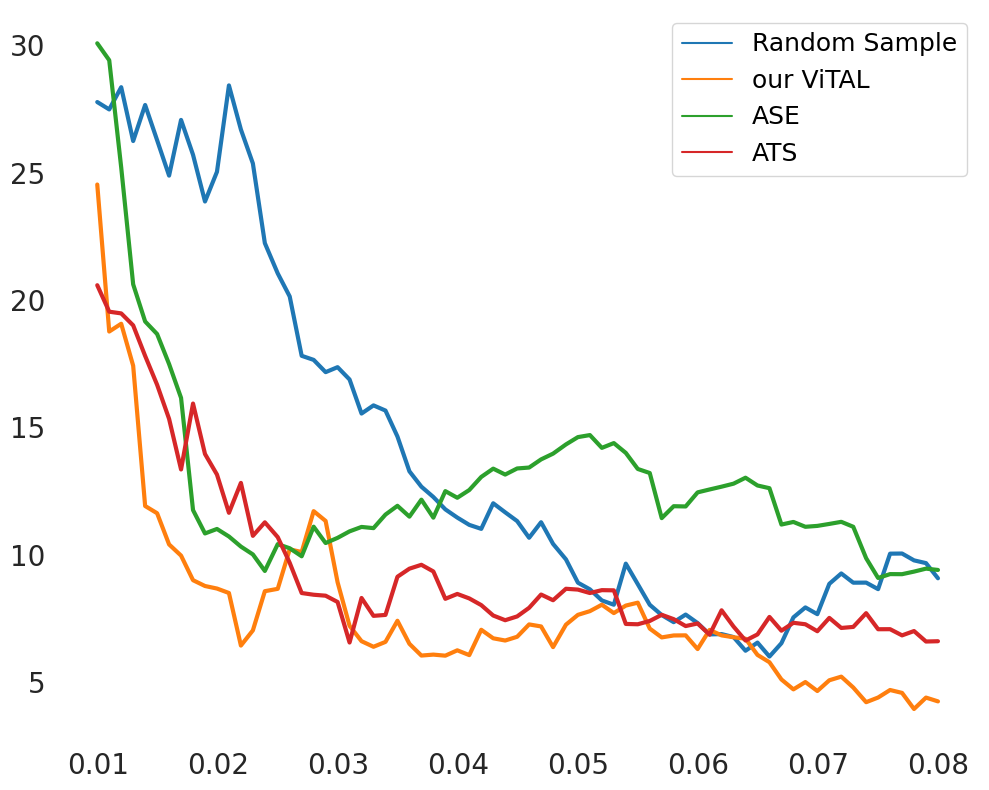

Max reducation compared with all approach: 0.80, loc : 0.017943409247757072, ours: 1.049025361197792, rs: 21.2339091098519, ase: 6.173016353944081, ats: 5.2601883781658625


In [253]:
results = take_region_16_data_for_defined_point("PSPNet_VOC",  10000)
results = results.append(take_region_16_data_for_defined_point("UNet_VOC",  25000))
results = results.append(take_region_16_data_for_defined_point("SEGNet_VOC_30",  5000))
results = results.append(take_region_16_data_for_defined_point("FCN_VOC",  10000))
plot_figure(results, "Region_16_VOC")

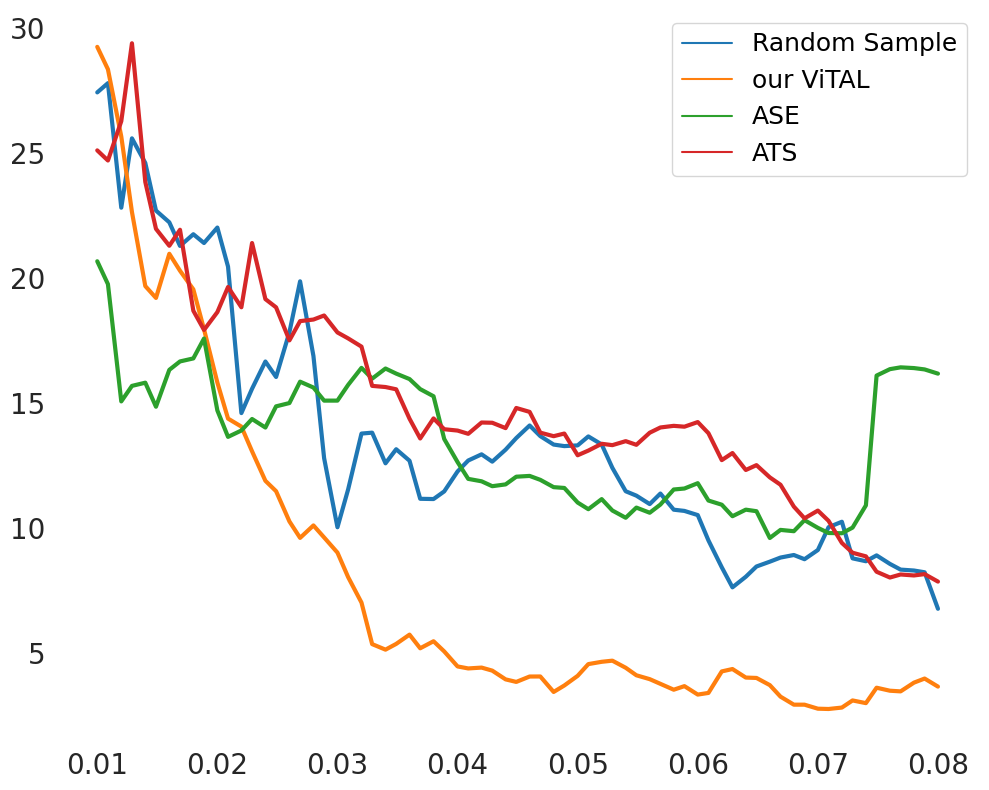

Max reducation compared with all approach: 0.88, loc : 0.06888888888888889, ours: 1.3654457988122584, rs: 11.841200033167413, ase: 11.588025795721563, ats: 19.558623329495493


In [276]:
results = take_region_16_data_for_defined_point("PSPNet_CITY",  10000)
results = results.append(take_region_16_data_for_defined_point("UNet_CITY_20", 20000))
results = results.append(take_region_16_data_for_defined_point("SEGNet_CITY",  10000))
results = results.append(take_region_16_data_for_defined_point("FCN_CITY_40",  15000))
plot_figure(results, "Region_16_CITY")

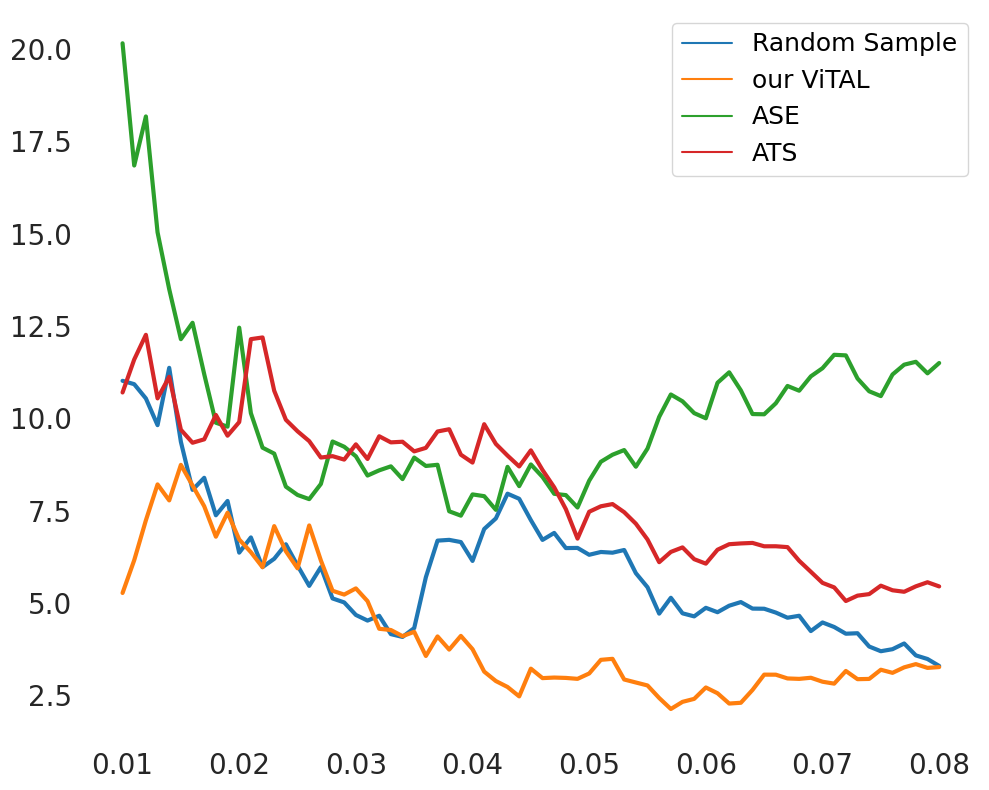

Max reducation compared with all approach: 0.89, loc : 0.027, ours: 0.7423160697510305, rs: 6.978348247393906, ase: 8.656600964555784, ats: 6.662700094021033


In [255]:
results = take_region_16_data_for_defined_point("PSPNet_COCO",  60000)
results = results.append(take_region_16_data_for_defined_point("UNet_COCO",  20000))
results = results.append(take_region_16_data_for_defined_point("SEGNet_COCO",  25000))
results = results.append(take_region_16_data_for_defined_point("FCN_COCO",  25000))
plot_figure(results, "Region_16_COCO")

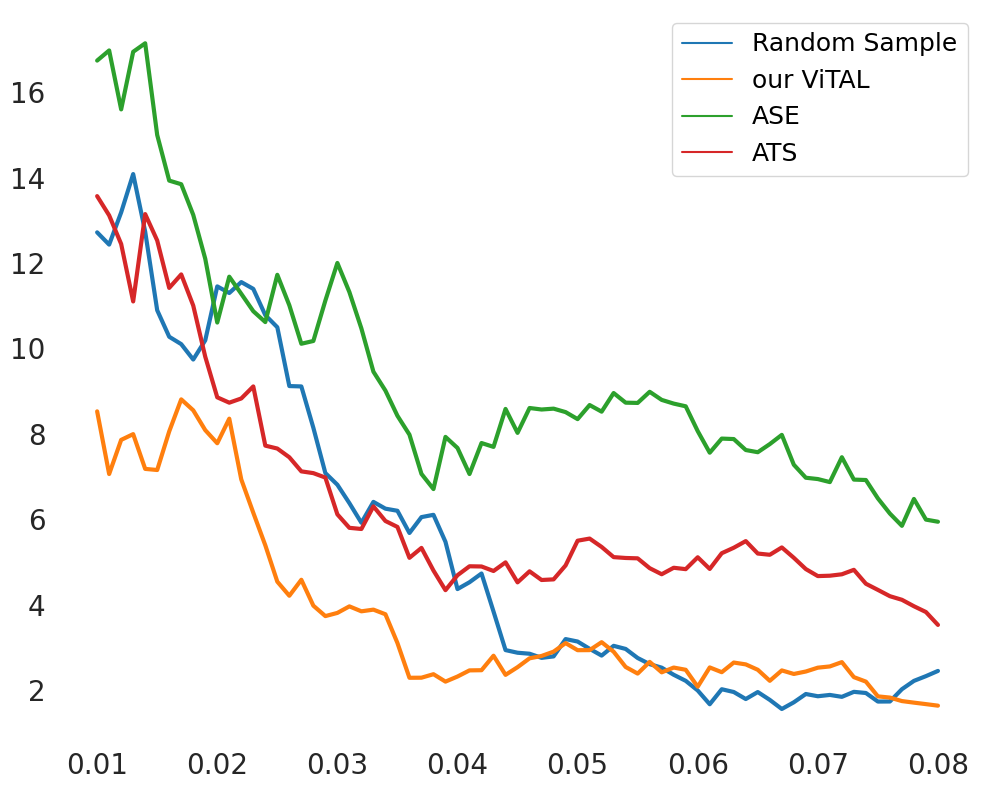

Max reducation compared with all approach: 0.90, loc : 0.02, ours: 0.5938031733702392, rs: 5.907466787140876, ase: 9.928491806833248, ats: 6.669388531189008


In [256]:
results = take_region_16_data_for_defined_point("PSPNet_ADE20K",  5000)
results = results.append(take_region_16_data_for_defined_point("UNet_ADE20K",  15000))
results = results.append(take_region_16_data_for_defined_point("SEGNet_ADE20K",  20000))
results = results.append(take_region_16_data_for_defined_point("FCN_ADE20K",  35000))
plot_figure(results, "Region_16_ADE20K")

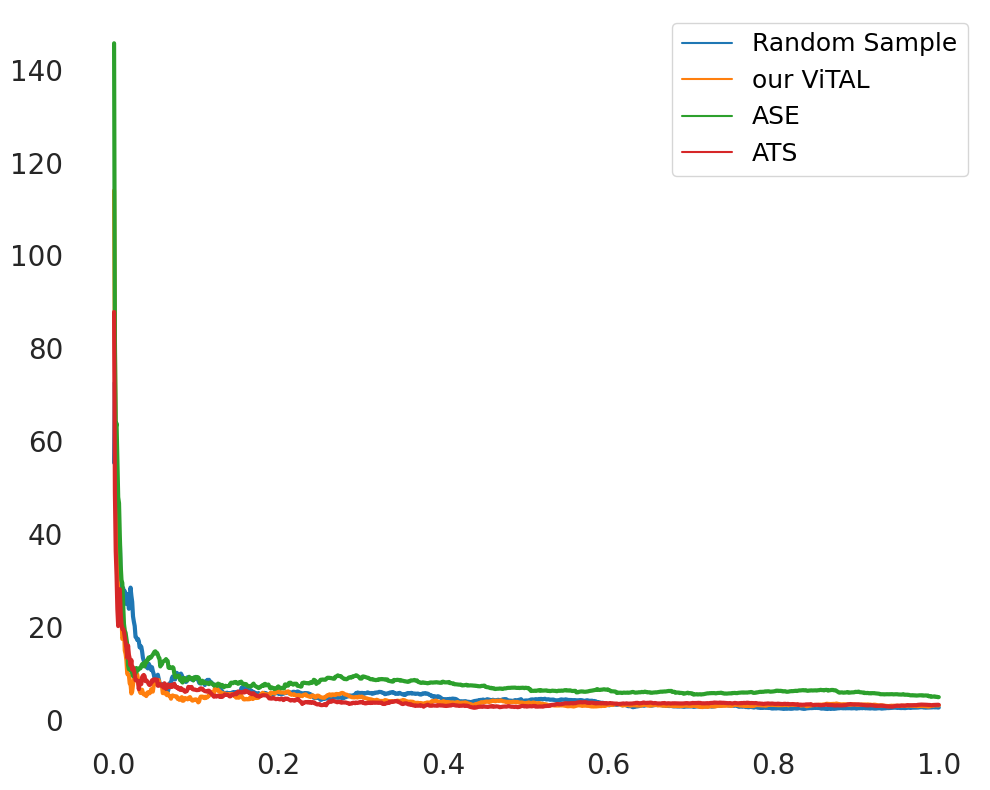

In [20]:
results = take_region_16_data_for_one_model_dataset("UNet_VOC", 25000)
results = results.append(take_region_16_data_for_one_model_dataset("PSPNet_VOC", 10000))
results = results.append(take_region_16_data_for_one_model_dataset("FCN_VOC", 10000))
results = results.append(take_region_16_data_for_one_model_dataset("SEGNet_VOC_40", 5000))
plot_figure(results)
# plot_figure(results, "Region_16_VOC")

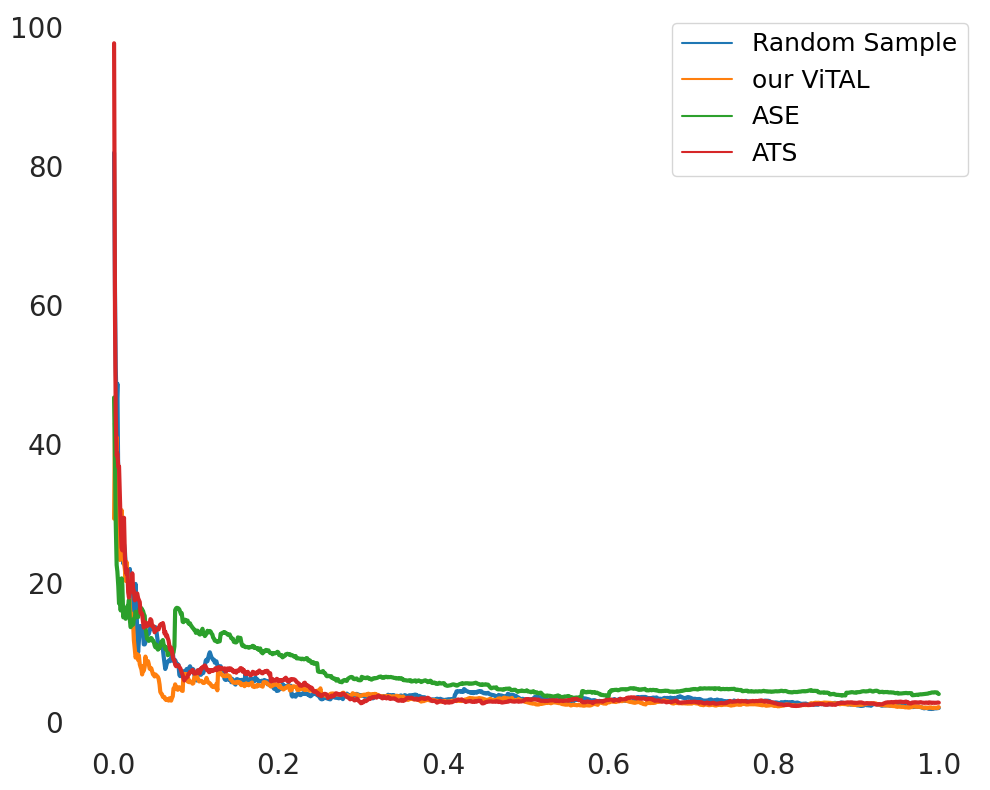

In [21]:
results = take_region_16_data_for_one_model_dataset("PSPNet_CITY", 10000)
results = results.append(take_region_16_data_for_one_model_dataset("UNet_CITY", 10000))
results = results.append(take_region_16_data_for_one_model_dataset("SEGNet_CITY", 10000))
results = results.append(take_region_16_data_for_one_model_dataset("FCN_CITY", 15000))
plot_figure(results)
# plot_figure(results, "Region_16_CITY")

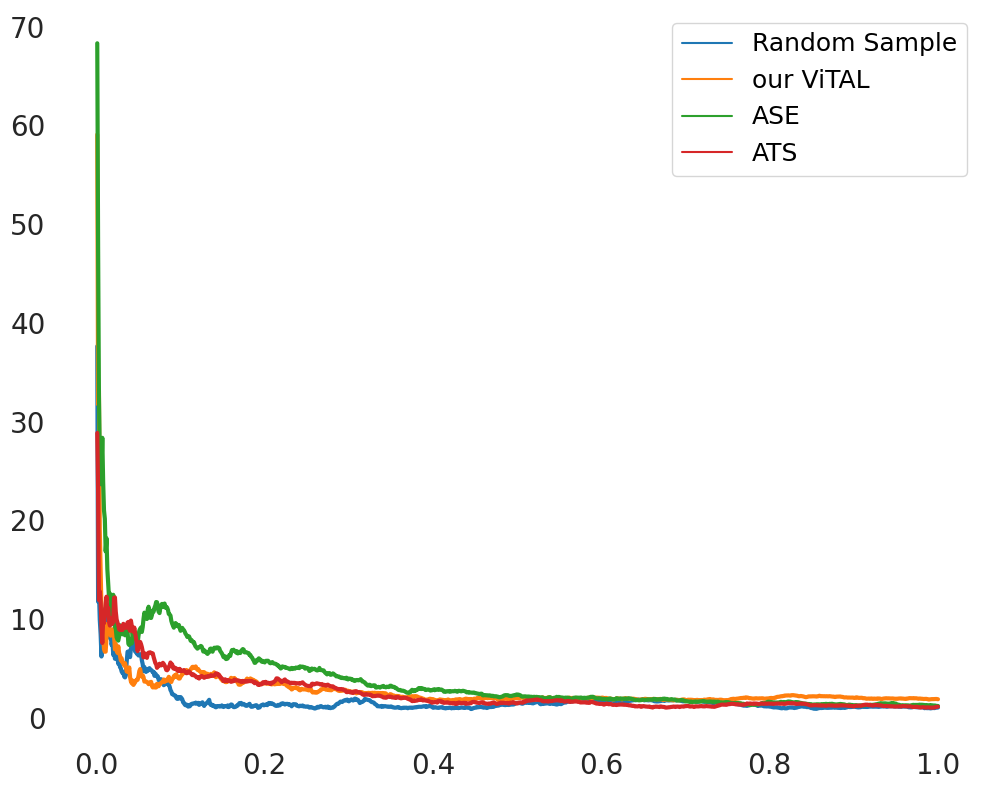

In [22]:
results = take_region_16_data_for_one_model_dataset("PSPNet_COCO", 60000)
results = results.append(take_region_16_data_for_one_model_dataset("UNet_COCO", 20000))
results = results.append(take_region_16_data_for_one_model_dataset("SEGNet_COCO", 25000))
results = results.append(take_region_16_data_for_one_model_dataset("FCN_COCO", 25000))
plot_figure(results)
# plot_figure(results, "Region_16_COCO")

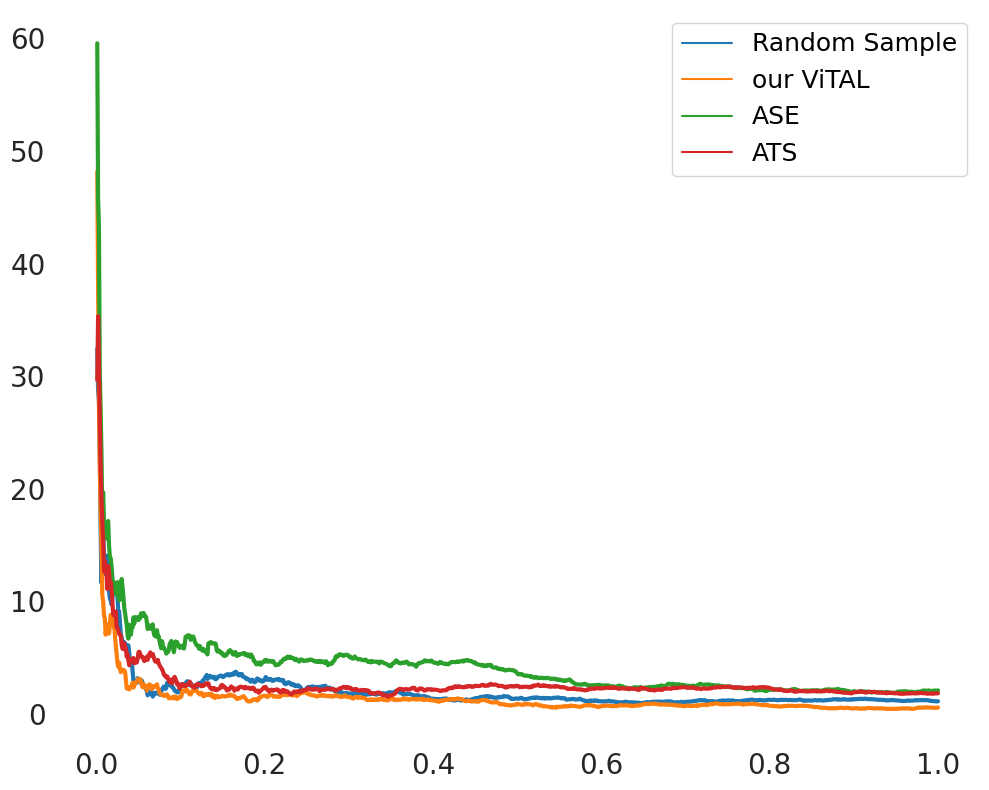

In [23]:
results = take_region_16_data_for_one_model_dataset("PSPNet_ADE20K", 5000)
results = results.append(take_region_16_data_for_one_model_dataset("UNet_ADE20K", 15000))
results = results.append(take_region_16_data_for_one_model_dataset("SEGNet_ADE20K", 20000))
results = results.append(take_region_16_data_for_one_model_dataset("FCN_ADE20K", 35000))
plot_figure(results)
# plot_figure(results, "Region_16_ADE20K")

## Region 32x32 based

In [257]:
store_folder = "runs_3_large_range"
method_dict = {"random sample": "Random Sample", "ViT region 32": "our ViTAL", "ASE region 32": "ASE", "AT region 32": "ATS"}
def take_region_32_data_for_one_model_dataset(model_dataset, steps = 10000):
    if model_dataset[-1] == "0":
        model_origin_folder = model_dataset[:-3]
    else:
        model_origin_folder = model_dataset
    base_path = f"./pro_data/{model_origin_folder}/val/"
    sample_size_threshold = np_read(base_path + "region_32_32_true_losses.npy").shape[0]
    result_json_path = f"./results/{store_folder}/{model_dataset}/region_32_32_active_testing/"
    true_loss_estimation_path = result_json_path + "None.json"
    test_whole_data = read_baseline_data(true_loss_estimation_path)
    results = add_entries(result_json_path + "random_sample_3_runs.json")
    results =  results.append(add_entries(result_json_path + f"ViT_region_runs_{steps}.json"),ignore_index=True)
    results =  results.append(add_entries(result_json_path + "ASE_runs.json"),ignore_index=True)
    results =  results.append(add_entries(result_json_path + "AT_runs.json"),ignore_index=True)
    y_metric = "loss"
    results[y_metric] = abs(results[y_metric] - test_whole_data[y_metric])
    results[y_metric] = results[y_metric] / test_whole_data[y_metric] * 100
    results['sample_size'] = results['sample_size'] / sample_size_threshold * 100
    return results

def take_region_32_data_for_defined_point(model_dataset,  steps = 10000):
    return take_data_for_defined_point(model_dataset,  steps, "region_32_32_true_losses.npy", "region_32_32_active_testing", "region")

def show_region_32_all_methods_mean_std(model_dataset, steps = 10000):
    show_all_methods_mean_std(model_dataset, steps, "region_32_32_true_losses.npy", "region_32_32_active_testing", "region")

min_size_p = 0.0002
max_size_p = 0.002

In [42]:
dataset_model = "FCN_VOC_40"

step_array = np.arange(5000, 20001, 5000)
for step in step_array:
    show_region_32_all_methods_mean_std(dataset_model, step)

./results/runs_3_large_range/FCN_VOC_40/region_32_32_active_testing/random_sample_3_runs.json: mean 11.07, std 4.78
./results/runs_3_large_range/FCN_VOC_40/region_32_32_active_testing/ViT_region_runs_5000.json: mean 10.43, std 2.00
./results/runs_3_large_range/FCN_VOC_40/region_32_32_active_testing/ASE_runs.json: mean 16.24, std 3.07
./results/runs_3_large_range/FCN_VOC_40/region_32_32_active_testing/AT_runs.json: mean 9.42, std 2.43
./results/runs_3_large_range/FCN_VOC_40/region_32_32_active_testing/random_sample_3_runs.json: mean 11.07, std 4.78
./results/runs_3_large_range/FCN_VOC_40/region_32_32_active_testing/ViT_region_runs_10000.json: mean 11.91, std 5.13
./results/runs_3_large_range/FCN_VOC_40/region_32_32_active_testing/ASE_runs.json: mean 16.24, std 3.07
./results/runs_3_large_range/FCN_VOC_40/region_32_32_active_testing/AT_runs.json: mean 9.42, std 2.43
./results/runs_3_large_range/FCN_VOC_40/region_32_32_active_testing/random_sample_3_runs.json: mean 11.07, std 4.78
./resul

In [65]:
result_pd = {}
temp_list = []
show_region_32_all_methods_mean_std("PSPNet_VOC", 5000)
print("====================================================================================================")
show_region_32_all_methods_mean_std("UNet_VOC_40", 5000)
print("====================================================================================================")
show_region_32_all_methods_mean_std("SEGNet_VOC", 10000)
print("====================================================================================================")
show_region_32_all_methods_mean_std("FCN_VOC_40", 15000)
print("====================================================================================================")
show_region_32_all_methods_mean_std("PSPNet_CITY", 15000)
print("====================================================================================================")
show_region_32_all_methods_mean_std("UNet_CITY", 20000)
print("====================================================================================================")
show_region_32_all_methods_mean_std("SEGNet_CITY", 15000)
print("====================================================================================================")
show_region_32_all_methods_mean_std("FCN_CITY", 20000)
print("====================================================================================================")
show_region_32_all_methods_mean_std("PSPNet_COCO", 15000)
show_region_32_all_methods_mean_std("UNet_COCO", 5000)
show_region_32_all_methods_mean_std("SEGNet_COCO", 20000)
show_region_32_all_methods_mean_std("FCN_COCO", 10000)

show_region_32_all_methods_mean_std("PSPNet_ADE20K", 30000)
show_region_32_all_methods_mean_std("UNet_ADE20K", 10000)
show_region_32_all_methods_mean_std("SEGNet_ADE20K", 5000)
show_region_32_all_methods_mean_std("FCN_ADE20K_90", 20000)
df = pd.DataFrame(result_pd)
df.to_excel('excel/region_32.xlsx', index=False)

./results/runs_3_large_range/PSPNet_VOC/region_32_32_active_testing/random_sample_3_runs.json: mean 18.42, std 6.75
./results/runs_3_large_range/PSPNet_VOC/region_32_32_active_testing/ViT_region_runs_5000.json: mean 11.72, std 1.52
./results/runs_3_large_range/PSPNet_VOC/region_32_32_active_testing/ASE_runs.json: mean 21.51, std 19.13
./results/runs_3_large_range/PSPNet_VOC/region_32_32_active_testing/AT_runs.json: mean 20.18, std 5.52
./results/runs_3_large_range/UNet_VOC/region_32_32_active_testing/random_sample_3_runs.json: mean 6.00, std 3.69
./results/runs_3_large_range/UNet_VOC/region_32_32_active_testing/ViT_region_runs_10000.json: mean 6.95, std 2.37
./results/runs_3_large_range/UNet_VOC/region_32_32_active_testing/ASE_runs.json: mean 5.02, std 0.92
./results/runs_3_large_range/UNet_VOC/region_32_32_active_testing/AT_runs.json: mean 5.13, std 1.41
./results/runs_3_large_range/SEGNet_VOC/region_32_32_active_testing/random_sample_3_runs.json: mean 19.75, std 10.24
./results/runs_

In [ ]:
# result_pd = {}
# temp_list = []
# show_region_32_all_methods_mean_std("PSPNet_VOC", 5000)
# print("====================================================================================================")
# show_region_32_all_methods_mean_std("UNet_VOC", 10000)
# print("====================================================================================================")
# show_region_32_all_methods_mean_std("SEGNet_VOC", 10000)
# print("====================================================================================================")
# show_region_32_all_methods_mean_std("FCN_VOC", 10000)
# print("====================================================================================================")
# show_region_32_all_methods_mean_std("PSPNet_CITY", 15000)
# print("====================================================================================================")
# show_region_32_all_methods_mean_std("UNet_CITY", 20000)
# print("====================================================================================================")
# show_region_32_all_methods_mean_std("SEGNet_CITY", 15000)
# print("====================================================================================================")
# show_region_32_all_methods_mean_std("FCN_CITY", 20000)
# print("====================================================================================================")
# df = pd.DataFrame(result_pd)
# df.to_excel('excel/region_32_VOC.xlsx', index=False)

In [ ]:
# result_pd = {}
# temp_list = []
# show_region_32_all_methods_mean_std("PSPNet_COCO", 15000)
# show_region_32_all_methods_mean_std("UNet_COCO", 5000)
# show_region_32_all_methods_mean_std("SEGNet_COCO", 20000)
# show_region_32_all_methods_mean_std("FCN_COCO", 10000)

# show_region_32_all_methods_mean_std("PSPNet_ADE20K", 10000)
# show_region_32_all_methods_mean_std("UNet_ADE20K", 10000)
# show_region_32_all_methods_mean_std("SEGNet_ADE20K", 5000)
# show_region_32_all_methods_mean_std("FCN_ADE20K_90", 20000)
# df = pd.DataFrame(result_pd)
# df.to_excel('excel/region_32_COCO.xlsx', index=False)

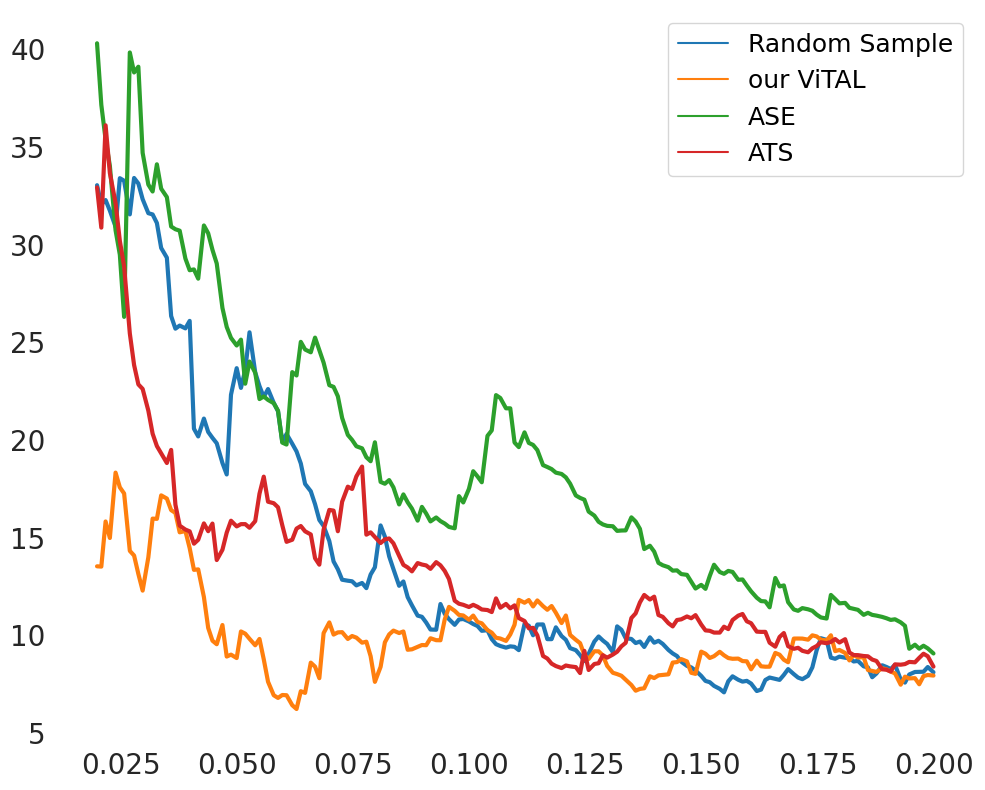

Max reducation compared with all approach: 0.83, loc : 0.029752319607392073, ours: 2.752437748765398, rs: 15.98820300526394, ase: 18.154606330645013, ats: 26.53980515069623


In [243]:
results = take_region_32_data_for_defined_point("PSPNet_VOC",  10000)
results = results.append(take_region_32_data_for_defined_point("UNet_VOC",  10000))
results = results.append(take_region_32_data_for_defined_point("SEGNet_VOC",  10000))
results = results.append(take_region_32_data_for_defined_point("FCN_VOC_40", 15000))
plot_figure(results, "Region_32_VOC")

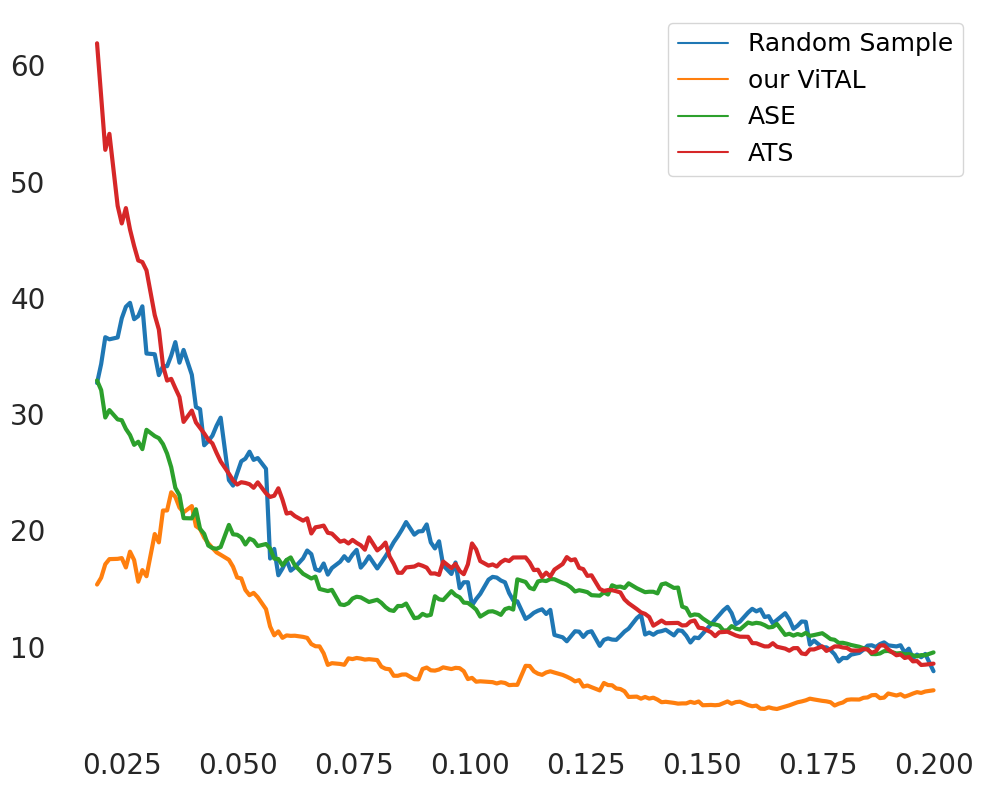

Max reducation compared with all approach: 0.87, loc : 0.08800000000000001, ours: 2.323219661610737, rs: 21.031443140572403, ase: 17.6803496382061, ats: 23.553939210171716


In [262]:
results = take_region_32_data_for_defined_point("PSPNet_CITY",  15000)
results = results.append(take_region_32_data_for_defined_point("UNet_CITY",  20000))
results = results.append(take_region_32_data_for_defined_point("SEGNet_CITY",  15000))
results = results.append(take_region_32_data_for_defined_point("FCN_CITY",  20000))
plot_figure(results, "Region_32_CITY")

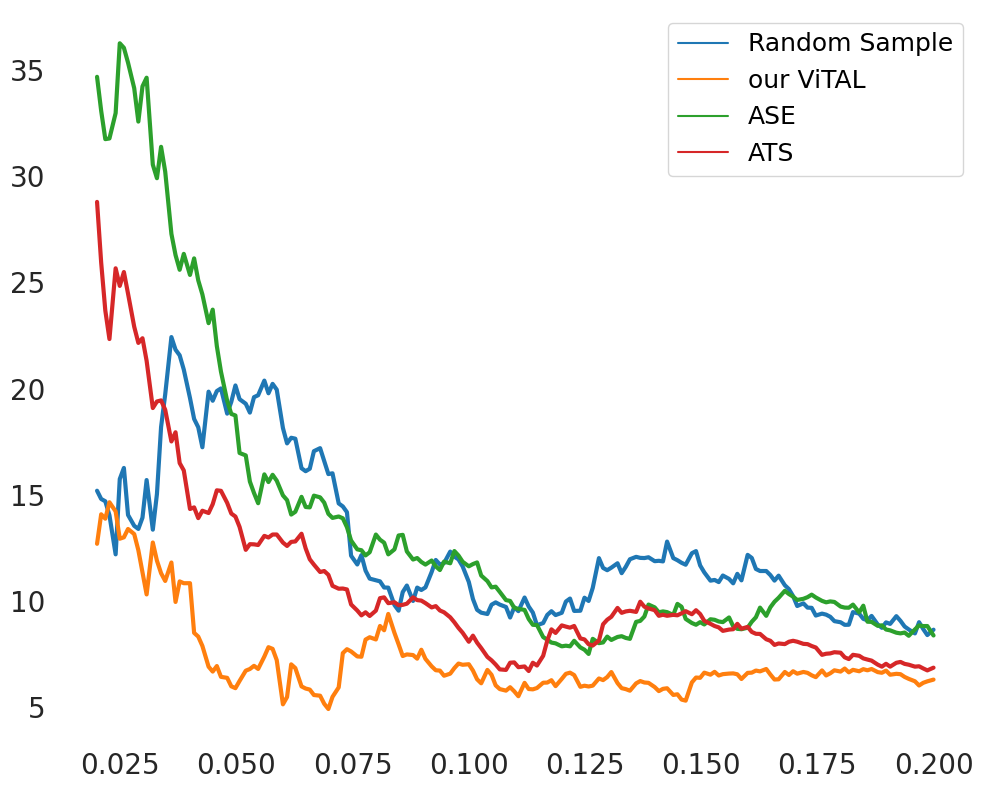

Max reducation compared with all approach: 0.89, loc : 0.049777777777777775, ours: 2.26590768854809, rs: 20.347212774987515, ase: 20.288349971083143, ats: 24.71124135131608


In [263]:
results = take_region_32_data_for_defined_point("PSPNet_COCO",  15000)
results = results.append(take_region_32_data_for_defined_point("UNet_COCO",  5000))
results = results.append(take_region_32_data_for_defined_point("SEGNet_COCO",  20000))
results = results.append(take_region_32_data_for_defined_point("FCN_COCO",  10000))
plot_figure(results, "Region_32_COCO")

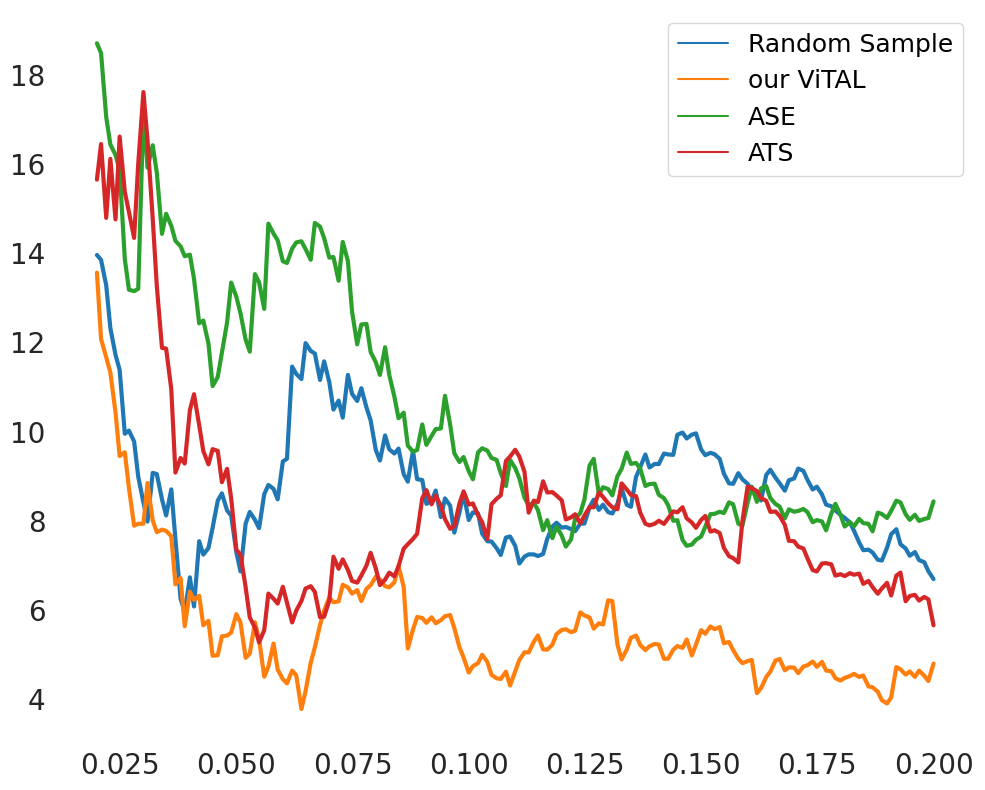

Max reducation compared with all approach: 0.87, loc : 0.034, ours: 0.8501386634577455, rs: 11.811776932012494, ase: 20.17808091692235, ats: 6.737165770492777


In [246]:
results = take_region_32_data_for_defined_point("PSPNet_ADE20K",  30000)
results = results.append(take_region_32_data_for_defined_point("UNet_ADE20K",  10000))
results = results.append(take_region_32_data_for_defined_point("SEGNet_ADE20K",  5000))
results = results.append(take_region_32_data_for_defined_point("FCN_ADE20K_90",  20000))
plot_figure(results, "Region_32_ADE20K")

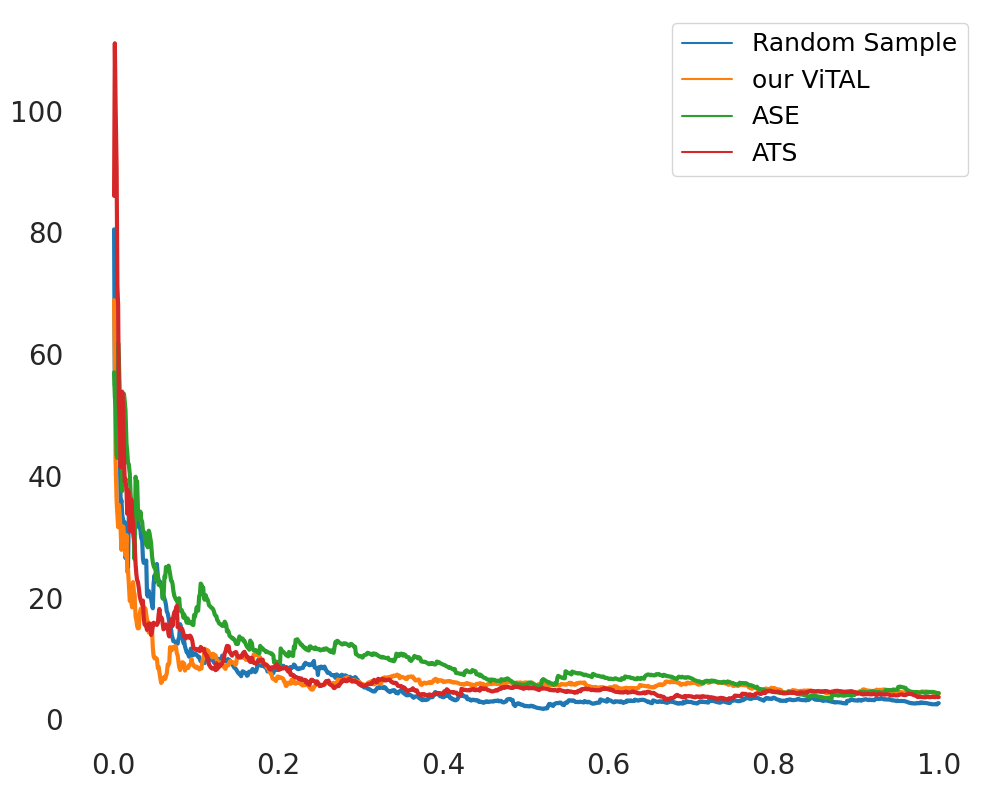

In [29]:
results = take_region_32_data_for_one_model_dataset("UNet_VOC", 10000)
results = results.append(take_region_32_data_for_one_model_dataset("PSPNet_VOC", 10000))
results = results.append(take_region_32_data_for_one_model_dataset("FCN_VOC", 10000))
results = results.append(take_region_32_data_for_one_model_dataset("SEGNet_VOC", 10000))
plot_figure(results)

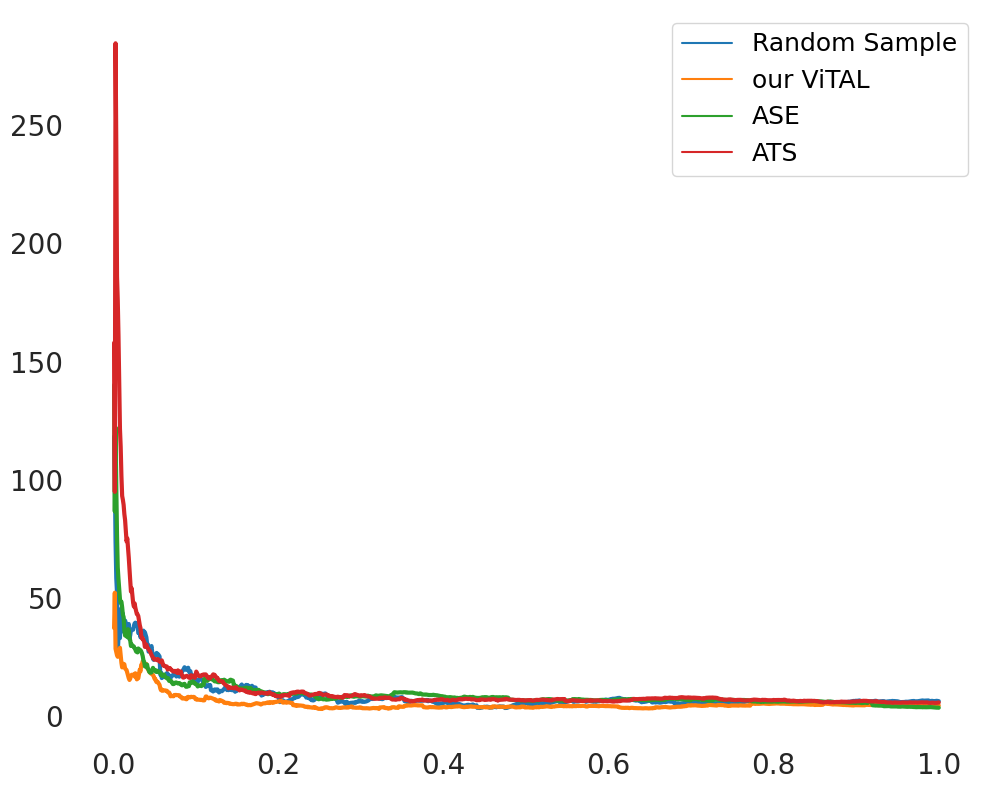

In [30]:
results = take_region_32_data_for_one_model_dataset("PSPNet_CITY", 15000)
results = results.append(take_region_32_data_for_one_model_dataset("UNet_CITY", 20000))
results = results.append(take_region_32_data_for_one_model_dataset("SEGNet_CITY", 15000))
results = results.append(take_region_32_data_for_one_model_dataset("FCN_CITY", 20000))
plot_figure(results)

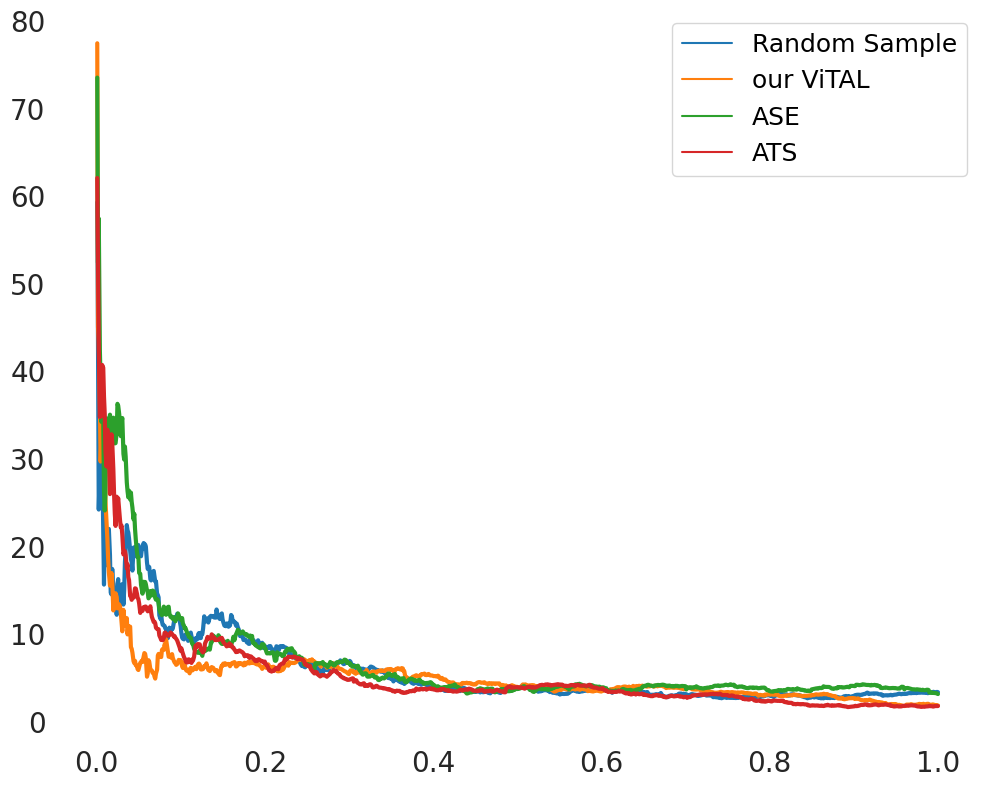

In [31]:
results = take_region_32_data_for_one_model_dataset("PSPNet_COCO", 15000)
results = results.append(take_region_32_data_for_one_model_dataset("UNet_COCO", 5000))
results = results.append(take_region_32_data_for_one_model_dataset("SEGNet_COCO", 20000))
results = results.append(take_region_32_data_for_one_model_dataset("FCN_COCO", 10000))
plot_figure(results)

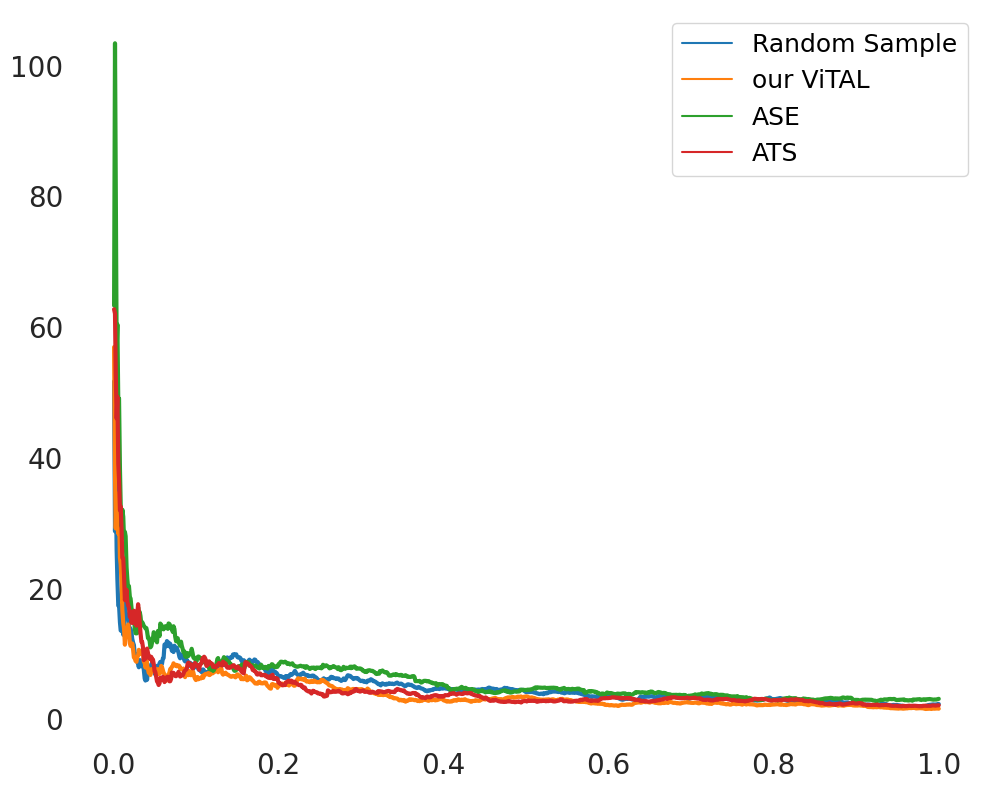

In [32]:
results = take_region_32_data_for_one_model_dataset("PSPNet_ADE20K", 10000)
results = results.append(take_region_32_data_for_one_model_dataset("UNet_ADE20K", 10000))
results = results.append(take_region_32_data_for_one_model_dataset("SEGNet_ADE20K", 5000))
results = results.append(take_region_32_data_for_one_model_dataset("FCN_ADE20K_90", 20000))
plot_figure(results)